# ☀️ Time Series Analysis & Temperature Forecasting with Weather data ☀️


## Motivation / Problem Statement

For some time, I have been interested in analyzing historical weather data to identify long-term climate trends and patterns. With the increasing occurrence of uncommon weather events in different regions, it has become even more important to understand how the temperature is changing over time. Have temperature variations, whether colder or hotter, influenced weather patterns over time?

### Weather Data Sources

I selected these datasets because of my interest in climate data and desire to explore the intricacies of time series analysis. By leveraging these datasets, I hope to identify meaningful trends and gain an understanding of the complex factors that influence the planet's climate. 
For a future extension, I will files to review temperature and weather events together.
 

[The Weather Dataset](https://www.kaggle.com/datasets/guillemservera/global-daily-climate-data?select=cities.csv) - 3 files

[US Weather Events (2016 - 2022)](https://www.kaggle.com/datasets/sobhanmoosavi/us-weather-events) - 1 file



#### Adding Kaggle Datasets to Kaggle notebooks

Under the Data section add dataset/s to use for your analysis

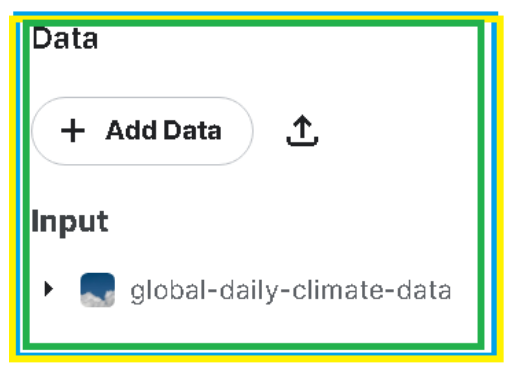



## Import Modules - Dependencies

Warnings are suppressed, but if the Python libraries are not installed an error will be generated - run the command below to install
    
<code>!pip install library_name<\code>   

In [1]:
import numpy as np
import pandas as pd
from pandas.plotting import lag_plot
from pandas.plotting import autocorrelation_plot

import seaborn as sns
sns.set(color_codes=True)
import seaborn.objects as so

import matplotlib.pyplot as plt
%matplotlib inline

from dateutil.parser import parse

In [2]:
from scipy import signal

from sklearn.preprocessing import LabelEncoder,OneHotEncoder
from sklearn.preprocessing import MinMaxScaler

from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.stattools import acf, pacf
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.ar_model import AutoReg
from statsmodels.tsa.arima_process import ArmaProcess
from statsmodels.tsa.statespace.sarimax import SARIMAX

from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_absolute_percentage_error

# Supress Warnings
import warnings
warnings.filterwarnings('ignore')

In [3]:
from keras.preprocessing.sequence import TimeseriesGenerator
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM

import tensorflow as tf
from tensorflow.keras import Model, Sequential
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.losses import MeanSquaredError
from tensorflow.keras.metrics import MeanAbsoluteError
from tensorflow.keras.layers import Dense, LSTM, Conv1D, Lambda, Reshape, RNN, LSTMCell

from prophet import Prophet
from prophet.plot import add_changepoints_to_plot

### Read Files 
 Retrieve data and load into dataframe 

 [The Weather Dataset](https://www.kaggle.com/datasets/guillemservera/global-daily-climate-data?select=cities.csv) 
 
---<b><u>cities data</b></u>---

station_id | city_name | country | state | iso2 | iso3 | latitude | longitude  

---<b><u>global weather data</b></u>---

station_id | city_name | date | season | avg_temp_c	| min_temp_c | max_temp_c | precipitation_mm | snow_depth_mm |

avg_wind_dir_deg | avg_wind_speed_kmh | peak_wind_gust_kmh | avg_sea_level_pres_hpa | sunshine_total_min

In [4]:
# dataset 1 - CSV
gbl_cities_data = pd.read_csv('/kaggle/input/global-daily-climate-data/cities.csv')

# dataset 1 - parquet file
gbl_weather_data = pd.read_parquet('/kaggle/input/global-daily-climate-data/daily_weather.parquet')

# Explore and Transform

#### Display Cities 
 Display the data to review the different columns

In [5]:
# display data
print(f"\n---cities data---\n")  
gbl_cities_data.sample(3)          # display random 3 rows to view data


---cities data---



station_id   city_name  country       state iso2 iso3   latitude  \
360       65404          Wa    Ghana  Upper West   GH  GHA  10.060405   
6         13577    Peshkopi  Albania       Dibër   AL  ALB  41.683302   
1195      86370  Tacuarembó  Uruguay  Tacuarembó   UY  URY -31.709965   

      longitude  
360   -2.500013  
6     20.433303  
1195 -55.980005

#### Review the data for missing values in columns

In [6]:
# review columns that include missing values from the different dataframes
print("---Cities data columns with missing values---\n")
print(gbl_cities_data.columns[gbl_cities_data.isnull().any()].tolist())

---Cities data columns with missing values---

['city_name', 'state', 'iso2']


In [7]:
# display missing values per column for countries and cities dataframes 
print("\n---cities data---")
print(gbl_cities_data.isnull().sum())


---cities data---
station_id     0
city_name      1
country        0
state         28
iso2           6
iso3           0
latitude       0
longitude      0
dtype: int64


### Copy the data 
to work on transformations without modifying original data. 

In [8]:
# Copy global cities dataframe to leave raw table in the original state
gbl_cities_data_mod = gbl_cities_data.copy()

## Drop columns (global) cities dataframes

In [9]:
# Drop columns and display remaining column names
gbl_cities_data_mod.drop(["iso2"], axis=1, inplace=True)

gbl_cities_data_mod.columns

Index(['station_id', 'city_name', 'country', 'state', 'iso3', 'latitude',
       'longitude'],
      dtype='object')

## Rename Countries

Review countries data to make sure the countries are consistent in names are consistent and same amount of countries are represented in both datasets.This is in preparation for merging the cities dataframe (doesn't include countries) and global weather data (only includes countries). 

In [11]:
# check unique countries in cities dataframe
print(f"Number of countries: {gbl_cities_data_mod['country'].nunique()}")
print(f"Country names: {gbl_cities_data_mod['country'].unique()}")

Number of countries: 216
Country names: ['Afghanistan' 'Albania' 'Algeria' 'American Samoa' 'Andorra' 'Angola'
 'Anguilla' 'Antigua and Barbuda' 'Argentina' 'Armenia' 'Aruba'
 'Australia' 'Austria' 'Azerbaijan' 'Bahrain' 'Bangladesh' 'Belarus'
 'Belgium' 'Belize' 'Benin' 'Bermuda' 'Bhutan' 'Bolivia'
 'Bosnia and Herzegovina' 'Botswana' 'Brazil' 'Brunei' 'Bulgaria'
 'Burkina Faso' 'Burundi' 'Cambodia' 'Cameroon' 'Canada' 'Cape Verde'
 'Cayman Islands' 'Central African Republic' 'Chad' 'Chile' 'China'
 'Christmas Island' 'Colombia' 'Comoros' 'Congo (Brazzaville)'
 'Congo (Kinshasa)' 'Cook Islands' 'Costa Rica' 'Croatia' 'Cuba' 'Cyprus'
 'Czech Republic' 'Denmark' 'Djibouti' 'Dominica' 'Dominican Republic'
 'East Timor' 'Ecuador' 'Egypt' 'El Salvador' 'Equatorial Guinea'
 'Estonia' 'Ethiopia' 'Falkland Islands' 'Fiji' 'Finland' 'France'
 'French Guiana' 'French Polynesia' 'French Southern and Antarctic Lands'
 'Gabon' 'Georgia' 'Germany' 'Ghana' 'Gibraltar' 'Greece' 'Greenland'
 'Grenada'

In [12]:
# Rename countries in cities dataframe to be consistent with countries dataframe
gbl_cities_data_mod = gbl_cities_data_mod.replace(['United States of America', 'Guinea Bissau', 'Svalbard and Jan Mayen Islands', 'Congo (Kinshasa)', 'Macau S.A.R', 'Congo (Brazzaville)'],['United States','Guinea-Bissau','Svalbard and Jan Mayen','Democratic Republic of the Congo','Macau','Republic of the Congo'])

### Filter out countries 
 Filter the dataframes so the country columns match when merged

In [13]:
# Filter out from gbl_cities_data_mod
values = ['Andorra', 'Montenegro', 'Myanmar']
gbl_cities_data_mod = gbl_cities_data_mod[gbl_cities_data_mod.country.isin(values) == False]

##### and states

In [14]:
# Filter out Hawaii and District of Columbia since they are not included in the US event dataset
values = ['Hawaii', 'District of Columbia' ]
gbl_cities_data_mod = gbl_cities_data_mod[gbl_cities_data_mod.city_name.isin(values) == False]

### Global Weather

The Global Weather includes the information for analysis - so will include some visualizations to review both datasets. First quick review of the first few rows of the global weather data.

#### Display the data to review the different columns

In [15]:
# display first three rows of the dataframe
gbl_weather_data.head(3)

station_id city_name       date  season  avg_temp_c  min_temp_c  max_temp_c  \
0      41515  Asadabad 1957-07-01  Summer        27.0        21.1        35.6   
1      41515  Asadabad 1957-07-02  Summer        22.8        18.9        32.2   
2      41515  Asadabad 1957-07-03  Summer        24.3        16.7        35.6   

   precipitation_mm  snow_depth_mm  avg_wind_dir_deg  avg_wind_speed_kmh  \
0               0.0            NaN               NaN                 NaN   
1               0.0            NaN               NaN                 NaN   
2               1.0            NaN               NaN                 NaN   

   peak_wind_gust_kmh  avg_sea_level_pres_hpa  sunshine_total_min  
0                 NaN                     NaN                 NaN  
1                 NaN                     NaN                 NaN  
2                 NaN                     NaN                 NaN

## Histogram Global Weather Data Distribution
Review the distribution of the data for the global weather data

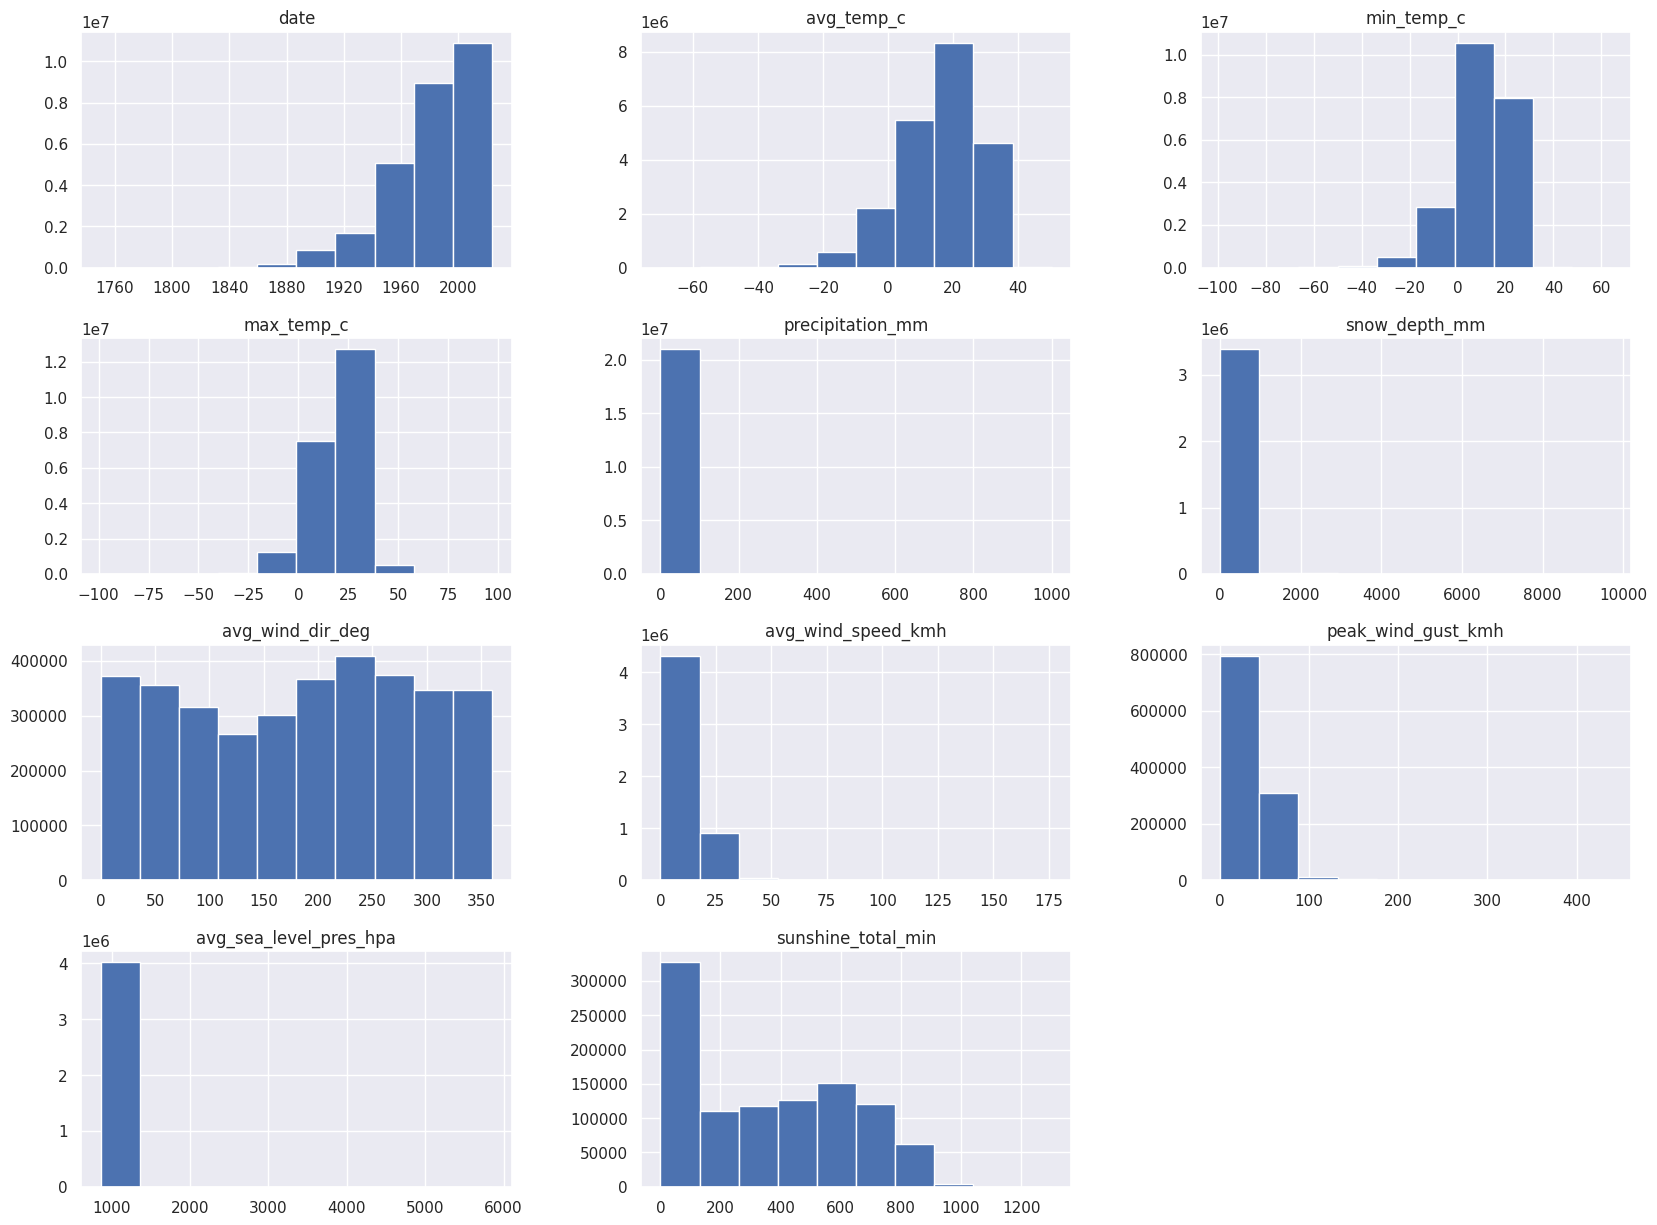

In [16]:
# display histograms
gbl_weather_data.hist(figsize=(20,15))
plt.show()

## Filter Weather data

Based on the histogram above narrow down the timeframe for the date column to decrease amount of rows read and speed things up.

#### Display date column, shape and min\max values

In [17]:
# display timeframe of the weather data
gbl_weather_data['date']

0       1957-07-01
1       1957-07-02
2       1957-07-03
3       1957-07-04
4       1957-07-05
           ...    
24216   2023-09-01
24217   2023-09-02
24218   2023-09-03
24219   2023-09-04
24220   2023-09-05
Name: date, Length: 27635763, dtype: datetime64[ns]

In [18]:
# display rows and columns
gbl_weather_data.shape

(27635763, 14)

In [19]:
# calculating Min and Max DateTimes to review timeframe range
print(f"min date: {gbl_weather_data['date'].min()}")
print(f"max date: {gbl_weather_data['date'].max()}")

min date: 1750-02-01 00:00:00
max date: 2023-09-05 00:00:00


## Filter Global Weather By Date

From the histogram it seems more of the data was captured after 1960's (70's and 80's). Randomly selected an 80's - 1982 as a start date and 12-31-2022 as an end date (for full yearly data capture) and to lessen the amount rows in the dataframe.

In [20]:
# Filter dates following a date range from histogram 
gweather_subset_date = \
   gbl_weather_data[(gbl_weather_data['date'] >= '1982-01-01 00:00:00') & (gbl_weather_data['date'] < '2023-01-01 00:00:00')]

In [21]:
# display rows and columns after filter
gweather_subset_date.shape

(15641531, 14)

## Drop Rows with Null values - Global Weather data

The global weather dataset at this point is still too large - by dropping rows with missing values will help decrease the amount of rows in the dataset. In order to later merge with the gbl_cities_data_mod to do some filtering by country.

In [22]:
# display columns with null values
print("\n---Weather data---")
print(gweather_subset_date.isnull().sum())


---Weather data---
station_id                       0
city_name                    13753
date                             0
season                           0
avg_temp_c                  719972
min_temp_c                 2883808
max_temp_c                 2481795
precipitation_mm           4849446
snow_depth_mm             13674550
avg_wind_dir_deg          12922471
avg_wind_speed_kmh        11295169
peak_wind_gust_kmh        14901403
avg_sea_level_pres_hpa    12586414
sunshine_total_min        15074844
dtype: int64


#### Drop rows
Drop rows with NaN and null values in columns

In [26]:
# Drop rows with NaN values in specific columns
gweather_subset_date.dropna(subset=['avg_temp_c','min_temp_c','max_temp_c','precipitation_mm','snow_depth_mm','avg_wind_dir_deg','avg_wind_speed_kmh','peak_wind_gust_kmh','avg_sea_level_pres_hpa','sunshine_total_min'],inplace=True)

In [27]:
# display columns with null values
print("\n---Weather data---")
print(gweather_subset_date.isnull().sum())


---Weather data---
station_id                0
city_name                 0
date                      0
season                    0
avg_temp_c                0
min_temp_c                0
max_temp_c                0
precipitation_mm          0
snow_depth_mm             0
avg_wind_dir_deg          0
avg_wind_speed_kmh        0
peak_wind_gust_kmh        0
avg_sea_level_pres_hpa    0
sunshine_total_min        0
dtype: int64


In [25]:
# review columns that include missing values from the different dataframes
print("Columns with missing values: ")
print(gweather_subset_date.columns[gweather_subset_date.isnull().any()].tolist())

Columns with missing values: 
[]


In [35]:
# display rows and columns after dropping NaN values
gweather_subset_date.shape

(284900, 14)

##  Merge dataframes - Global Cities and Global Weather data 

Merged the datasets in order to connect the cities data with the weather data and perform the time series analysis. Before merging review datatypes, columns, and shape.

In [28]:
# display information about a DataFrame
gweather_subset_date.info()

<class 'pandas.core.frame.DataFrame'>
Index: 284900 entries, 6266 to 22432
Data columns (total 14 columns):
 #   Column                  Non-Null Count   Dtype         
---  ------                  --------------   -----         
 0   station_id              284900 non-null  category      
 1   city_name               284900 non-null  category      
 2   date                    284900 non-null  datetime64[ns]
 3   season                  284900 non-null  category      
 4   avg_temp_c              284900 non-null  float64       
 5   min_temp_c              284900 non-null  float64       
 6   max_temp_c              284900 non-null  float64       
 7   precipitation_mm        284900 non-null  float64       
 8   snow_depth_mm           284900 non-null  float64       
 9   avg_wind_dir_deg        284900 non-null  float64       
 10  avg_wind_speed_kmh      284900 non-null  float64       
 11  peak_wind_gust_kmh      284900 non-null  float64       
 12  avg_sea_level_pres_hpa  284900 no

In [29]:
# display information about a DataFrame
gbl_cities_data_mod.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1238 entries, 0 to 1244
Data columns (total 7 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   station_id  1238 non-null   object 
 1   city_name   1237 non-null   object 
 2   country     1238 non-null   object 
 3   state       1211 non-null   object 
 4   iso3        1238 non-null   object 
 5   latitude    1238 non-null   float64
 6   longitude   1238 non-null   float64
dtypes: float64(2), object(5)
memory usage: 77.4+ KB


In [30]:
# display dataframes before merge
print(gweather_subset_date.shape)
print(gbl_cities_data_mod.shape)

(284900, 14)
(1238, 7)


## Merge dataframes to a new cities_weather dataframe

Merge the datasets on station_id since both datasets have that column in common. 

Merging in order to analyze the global weather data - global weather data does not include the country data which is needed to observe country weather changes over the years.

In [31]:
# Merge dataframe
cities_weather = pd.merge(gweather_subset_date, gbl_cities_data_mod,left_on='station_id',right_on='station_id',how='inner')

In [32]:
# display merged rows and columns
cities_weather.shape

(295912, 20)

In [33]:
# display datatypes
cities_weather.dtypes

station_id                        object
city_name_x                     category
date                      datetime64[ns]
season                          category
avg_temp_c                       float64
min_temp_c                       float64
max_temp_c                       float64
precipitation_mm                 float64
snow_depth_mm                    float64
avg_wind_dir_deg                 float64
avg_wind_speed_kmh               float64
peak_wind_gust_kmh               float64
avg_sea_level_pres_hpa           float64
sunshine_total_min               float64
city_name_y                       object
country                           object
state                             object
iso3                              object
latitude                         float64
longitude                        float64
dtype: object

#### Drop rows with NaN for the specified columns

Filter out Unknown values for states and drop NaN values

In [34]:
# Drop rows with NaN values in specific columns
cities_weather.dropna(subset=['avg_temp_c','min_temp_c','max_temp_c','precipitation_mm','snow_depth_mm','avg_wind_dir_deg','avg_wind_speed_kmh',\
                                    'peak_wind_gust_kmh','avg_sea_level_pres_hpa','sunshine_total_min','state'],inplace=True)

In [35]:
# display columns with null values - duplicated columns will be dropped in another cell
print("\n---Weather data---")
print(cities_weather.isnull().sum())


---Weather data---
station_id                0
city_name_x               0
date                      0
season                    0
avg_temp_c                0
min_temp_c                0
max_temp_c                0
precipitation_mm          0
snow_depth_mm             0
avg_wind_dir_deg          0
avg_wind_speed_kmh        0
peak_wind_gust_kmh        0
avg_sea_level_pres_hpa    0
sunshine_total_min        0
city_name_y               0
country                   0
state                     0
iso3                      0
latitude                  0
longitude                 0
dtype: int64


Reviewing state in the merged dataset after dropping NaNs now drop Unknowns included in rows.

In [36]:
# display unique states
print(cities_weather['state'].unique())

['Unknown' 'Sjaælland' 'Berlin' 'Bremen' 'Nordrhein-Westfalen' 'Thüringen'
 'Hamburg' 'Niedersachsen' 'Schleswig-Holstein' 'Sachsen-Anhalt' 'Bayern'
 'Brandenburg' 'Mecklenburg-Vorpommern' 'Baden-Württemberg' 'Skåne'
 'Thurgau' 'New York' 'Maryland' 'Georgia' 'North Dakota' 'Idaho'
 'Massachusetts' 'Nevada' 'West Virginia' 'Wyoming' 'South Carolina'
 'Ohio' 'New Hampshire' 'Colorado' 'Iowa' 'Connecticut' 'Montana' 'Hawaii'
 'Indiana' 'Missouri' 'Michigan' 'Nebraska' 'Wisconsin' 'Alabama'
 'Tennessee' 'Oklahoma' 'Arizona' 'Rhode Island' 'North Carolina'
 'Virginia' 'Minnesota' 'Utah' 'New Mexico' 'Illinois' 'Kansas'
 'New Jersey' 'District of Columbia']


In [47]:
# Filter Severity events that are Moderate, Unknown or Other
state_unk = ['Unknown']
cities_weather = cities_weather[cities_weather.state.isin(state_unk) == False]

In [37]:
# display unique seasons to check if Unknowns or NaNs are included
print(cities_weather['season'].unique())

['Summer', 'Autumn', 'Winter', 'Spring']
Categories (4, object): ['Autumn', 'Spring', 'Summer', 'Winter']


#### Drop Columns

Drop duplicate city_name created when dataframes were merged. 
Also remove iso3 (3 letter representation of country), station_id, and state, since analysis will analysis will be done by countries.

In [38]:
# Drop extra city_name column city_name_y created when dataframes were merged & other cols
cities_weather.drop(["city_name_x", "iso3", "station_id", "state"], axis=1, inplace=True)

In [39]:
# Rename city_name_x back to city_name
cities_weather.rename(columns = {"city_name_y":'city_name'}, inplace = True)

In [40]:
# display merged dataframe columns
cities_weather.columns

Index(['date', 'season', 'avg_temp_c', 'min_temp_c', 'max_temp_c',
       'precipitation_mm', 'snow_depth_mm', 'avg_wind_dir_deg',
       'avg_wind_speed_kmh', 'peak_wind_gust_kmh', 'avg_sea_level_pres_hpa',
       'sunshine_total_min', 'city_name', 'country', 'latitude', 'longitude'],
      dtype='object')

In [41]:
print("\nMININUM\n")
print(f"Avg Temperature Min value: {cities_weather['avg_temp_c'].min()}")
print(f"Max Temperature Min value: {cities_weather['max_temp_c'].min()}")
print(f"Max Temperature Min value: {cities_weather['min_temp_c'].min()}")
print("\nMAXINUM\n")
print(f"Avg Temperature Max value: {cities_weather['avg_temp_c'].max()}")
print(f"Max Temperature Max value: {cities_weather['max_temp_c'].max()}")
print(f"Max Temperature Max value: {cities_weather['min_temp_c'].max()}")


MININUM

Avg Temperature Min value: -32.2
Max Temperature Min value: -30.6
Max Temperature Min value: -35.0

MAXINUM

Avg Temperature Max value: 40.1
Max Temperature Max value: 47.8
Max Temperature Max value: 33.9


#### Visualize average/max/min temperature and season data

(array([0, 1, 2, 3, 4, 5]),
 [Text(0, 0, 'Samoa'),
  Text(1, 0, 'Denmark'),
  Text(2, 0, 'Germany'),
  Text(3, 0, 'Sweden'),
  Text(4, 0, 'Switzerland'),
  Text(5, 0, 'United States')])

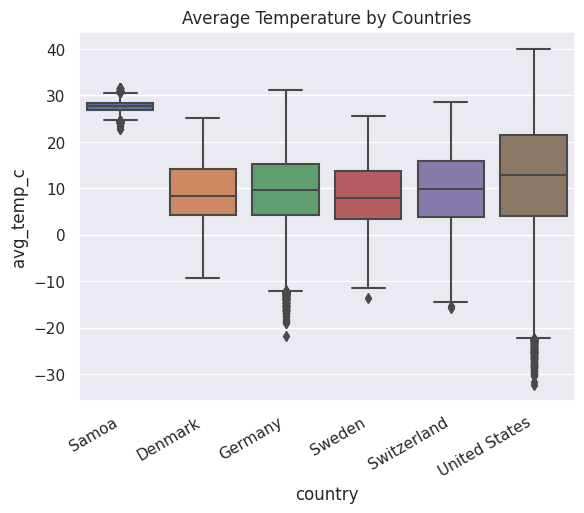

In [42]:
# boxplot countries - average temperature
sns.boxplot(data=cities_weather, x ='country', y ='avg_temp_c').set_title('Average Temperature by Countries')
plt.xticks(rotation=30, ha='right')

(array([0, 1, 2, 3, 4, 5]),
 [Text(0, 0, 'Samoa'),
  Text(1, 0, 'Denmark'),
  Text(2, 0, 'Germany'),
  Text(3, 0, 'Sweden'),
  Text(4, 0, 'Switzerland'),
  Text(5, 0, 'United States')])

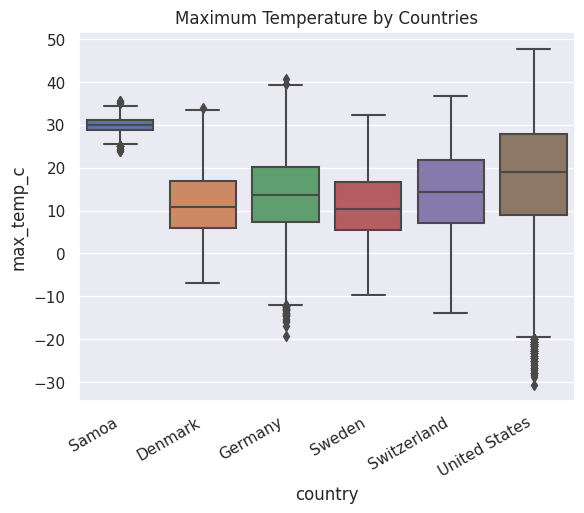

In [43]:
# boxplot countries - max temperature
sns.boxplot(data=cities_weather, x ='country', y ='max_temp_c').set_title('Maximum Temperature by Countries')
plt.xticks(rotation=30, ha='right')

(array([0, 1, 2, 3, 4, 5]),
 [Text(0, 0, 'Samoa'),
  Text(1, 0, 'Denmark'),
  Text(2, 0, 'Germany'),
  Text(3, 0, 'Sweden'),
  Text(4, 0, 'Switzerland'),
  Text(5, 0, 'United States')])

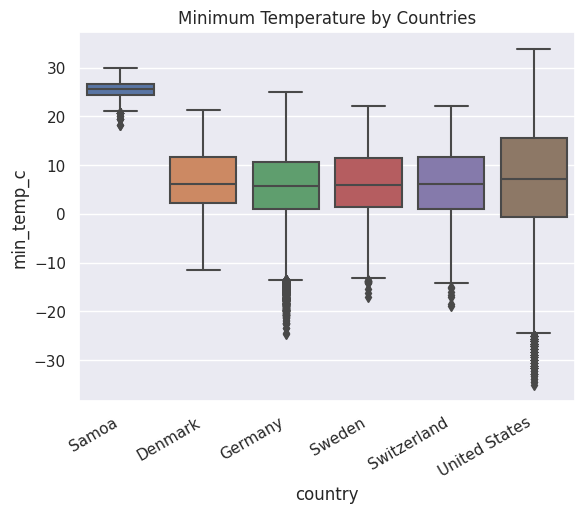

In [44]:
# boxplot countries - min temperature
sns.boxplot(data=cities_weather, x ='country', y ='min_temp_c').set_title('Minimum Temperature by Countries')
plt.xticks(rotation=30, ha='right')

(array([0, 1, 2, 3]),
 [Text(0, 0, 'Autumn'),
  Text(1, 0, 'Spring'),
  Text(2, 0, 'Summer'),
  Text(3, 0, 'Winter')])

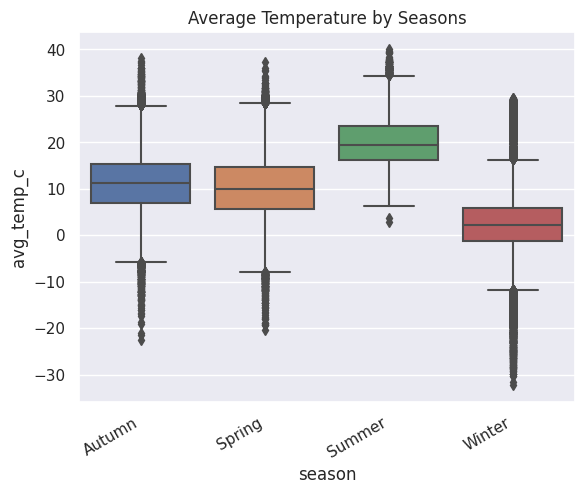

In [45]:
# boxplot seasons - average temperature
sns.boxplot(data=cities_weather, x ='season', y ='avg_temp_c').set_title('Average Temperature by Seasons')
plt.xticks(rotation=30, ha='right')

### Clip outliers

Based on visuals above - decided to remove extreme outliers and visualize updated data

In [48]:
# Remove extreme outliers shown on boxplots for Max Temp
upper_threshold = 30 # threshold for outliers
lower_threshold = 0

cities_weather['avg_temp_c'][(cities_weather['avg_temp_c'] > upper_threshold) | (cities_weather['avg_temp_c'] < lower_threshold)]

# Clip values to the specified bounds
cities_weather['avg_temp_c'] = cities_weather['avg_temp_c'].clip(lower=lower_threshold, upper=upper_threshold)

cities_weather.head(3)

date  season  avg_temp_c  min_temp_c  max_temp_c  precipitation_mm  \
1 1982-01-01  Summer        26.6        25.0        28.3              43.4   
3 1982-01-02  Summer        27.0        25.0        30.6               3.3   
5 1982-01-03  Summer        27.5        24.4        30.6               2.5   

   snow_depth_mm  avg_wind_dir_deg  avg_wind_speed_kmh  peak_wind_gust_kmh  \
1            0.0             338.0                28.7                85.0   
3            0.0               2.0                24.4                59.0   
5            0.0              54.0                14.5                37.1   

   avg_sea_level_pres_hpa  sunshine_total_min city_name country   latitude  \
1                  1008.6                30.0      Apia   Samoa -13.834369   
3                  1009.9               210.0      Apia   Samoa -13.834369   
5                  1010.1               486.0      Apia   Samoa -13.834369   

    longitude  
1 -171.769279  
3 -171.769279  
5 -171.769279

(array([0, 1, 2, 3, 4, 5]),
 [Text(0, 0, 'Samoa'),
  Text(1, 0, 'Denmark'),
  Text(2, 0, 'Germany'),
  Text(3, 0, 'Sweden'),
  Text(4, 0, 'Switzerland'),
  Text(5, 0, 'United States')])

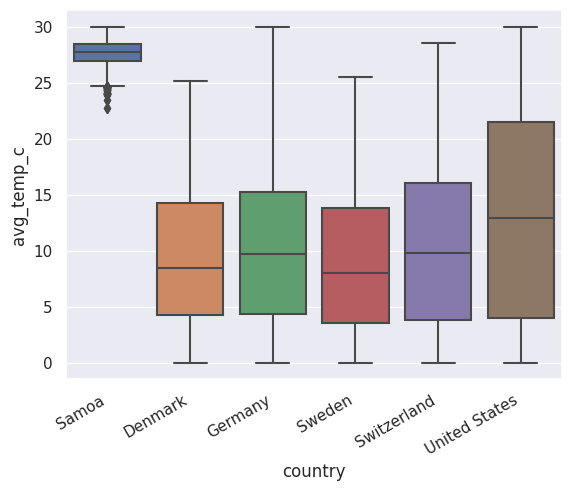

In [49]:
# box plot - max temperature with removing outliers
sns.boxplot(data=cities_weather, x ='country', y ='avg_temp_c')
plt.xticks(rotation=30, ha='right')

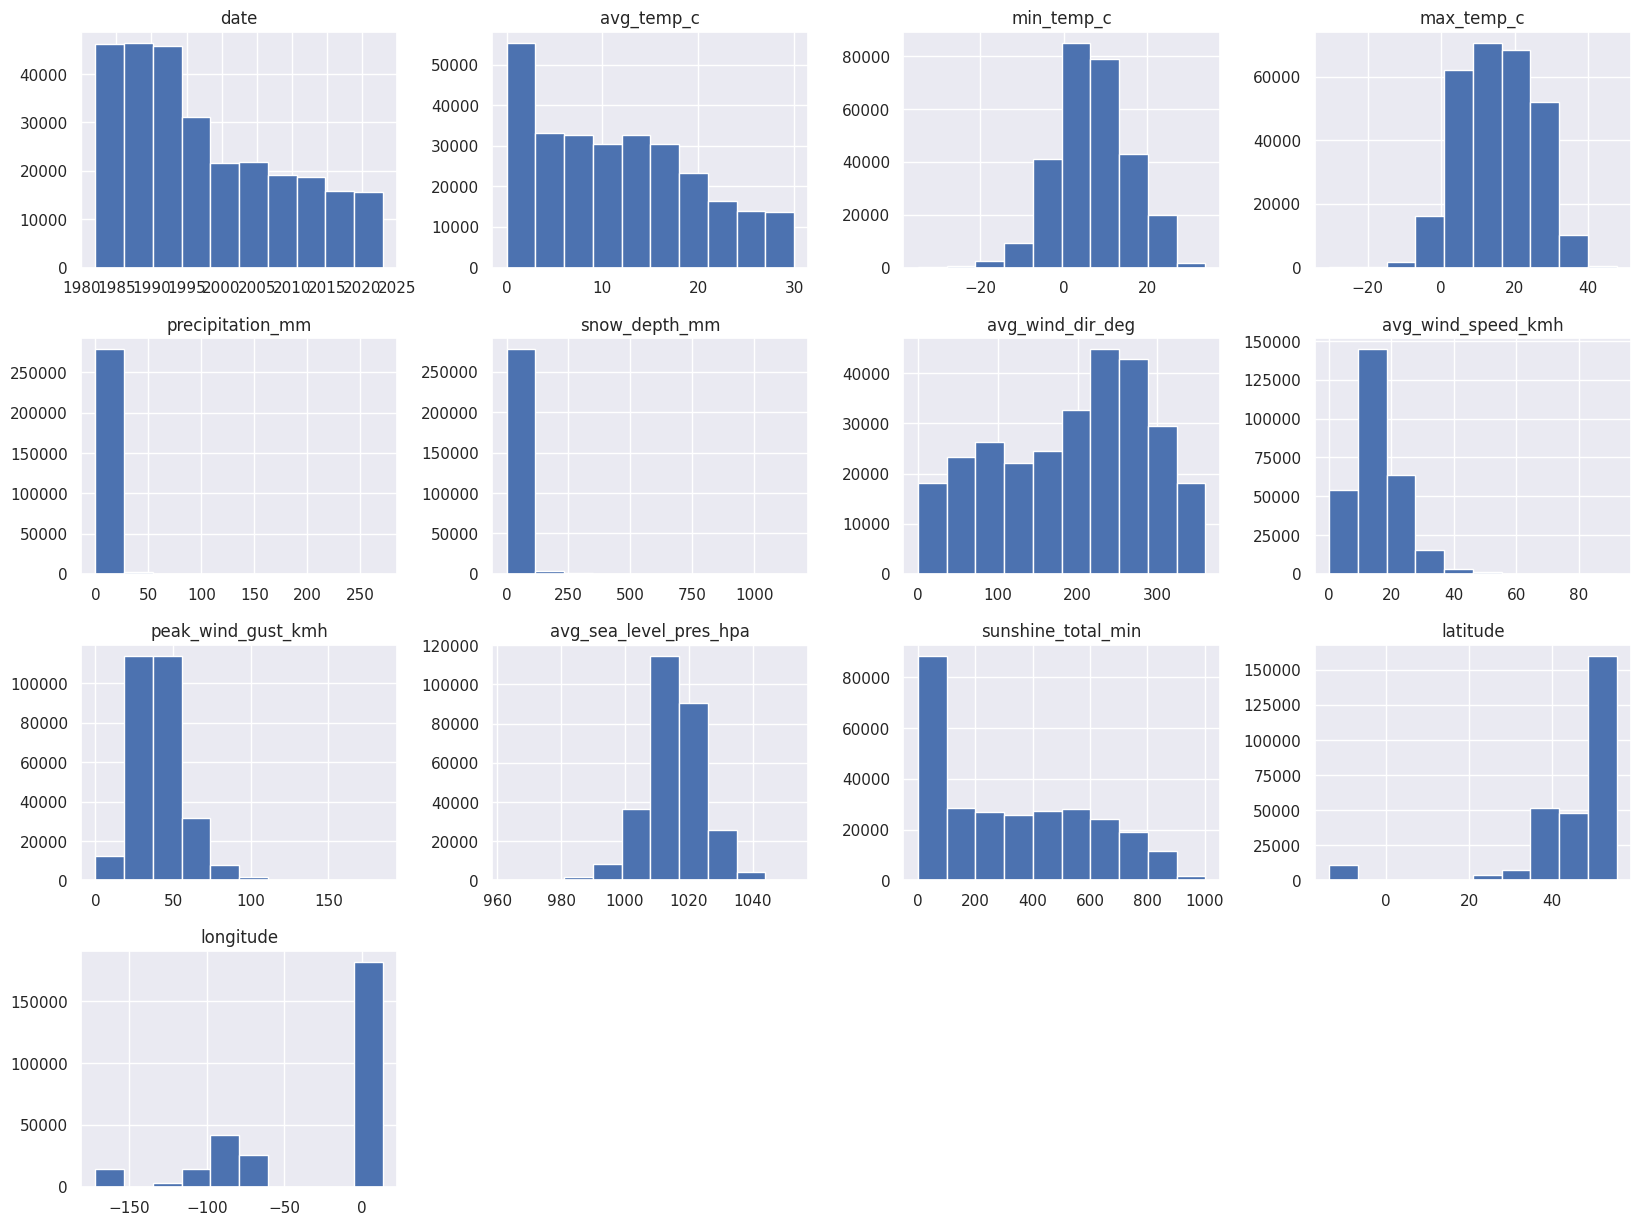

In [50]:
# display histogram to review distribution after outlier removal
cities_weather.hist(figsize=(20,15))
plt.show()

#### Summary statistics

View some basic statistical details

In [51]:
# summary statistics for United States subset
cities_weather.describe(include='all')

date  season     avg_temp_c     min_temp_c  \
count                          281999  281999  281999.000000  281999.000000   
unique                            NaN       4            NaN            NaN   
top                               NaN  Spring            NaN            NaN   
freq                              NaN   73729            NaN            NaN   
mean    1997-08-20 14:24:19.486026496     NaN      11.514671       6.899794   
min               1982-01-01 00:00:00     NaN       0.000000     -35.000000   
25%               1988-03-24 00:00:00     NaN       4.400000       0.900000   
50%               1994-07-18 00:00:00     NaN      10.900000       6.700000   
75%               2006-04-18 00:00:00     NaN      17.600000      12.700000   
max               2022-12-31 00:00:00     NaN      30.000000      33.900000   
std                               NaN     NaN       8.354112       8.798651   

           max_temp_c  precipitation_mm  snow_depth_mm  avg_wind_dir_deg  \
count   281999.000000     281999.000000  281999.000000     281999.000000   
unique            NaN               NaN            NaN               NaN   
top               NaN               NaN            NaN               NaN   
freq              NaN               NaN            NaN               NaN   
mean        15.421792          2.311849       5.854943        192.586506   
min        -30.600000          0.000000       0.000000          0.000000   
25%          7.600000          0.000000       0.000000        112.000000   
50%         15.400000          0.000000       0.000000        210.000000   
75%         23.100000          1.700000       0.000000        267.000000   
max         47.800000        271.300000    1161.000000        360.000000   
std         10.056583          6.661915      31.022086         94.540655   

        avg_wind_speed_kmh  peak_wind_gust_kmh  avg_sea_level_pres_hpa  \
count        281999.000000       281999.000000           281999.000000   
unique                 NaN                 NaN                     NaN   
top                    NaN                 NaN                     NaN   
freq                   NaN                 NaN                     NaN   
mean             15.721846           40.522926             1015.537092   
min               0.000000            0.000000              962.900000   
25%              10.400000           29.500000             1010.400000   
50%              14.800000           38.500000             1015.600000   
75%              19.800000           49.000000             1020.900000   
max              92.200000          185.000000             1053.000000   
std               7.639066           15.634652                8.700704   

        sunshine_total_min city_name  country       latitude      longitude  
count        281999.000000    281999   281999  281999.000000  281999.000000  
unique                 NaN        52        6            NaN            NaN  
top                    NaN   Hamburg  Germany            NaN            NaN  
freq                   NaN     14894   145739            NaN            NaN  
mean            323.590704       NaN      NaN      45.397693     -28.960234  
min               0.000000       NaN      NaN     -13.834369    -171.769279  
25%              47.000000       NaN      NaN      41.579980     -84.399949  
50%             291.000000       NaN      NaN      50.970053       9.108001  
75%             553.000000       NaN      NaN      52.521819      11.416699  
max            1002.000000       NaN      NaN      55.583337      13.401549  
std             274.116824       NaN      NaN      13.752929      56.240458

#### Scatter plots to review the different numerial features

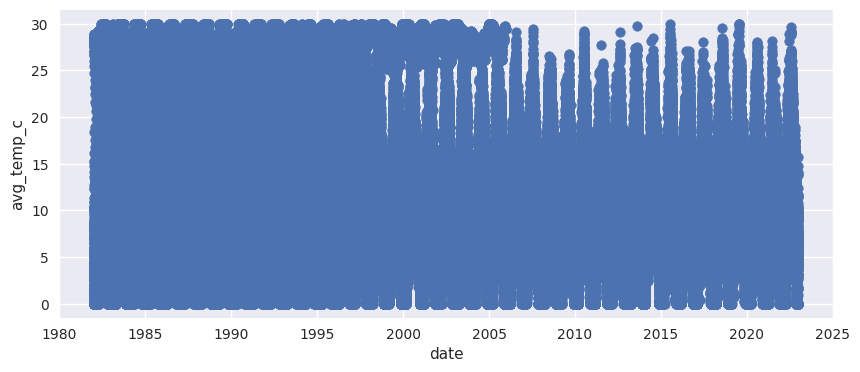

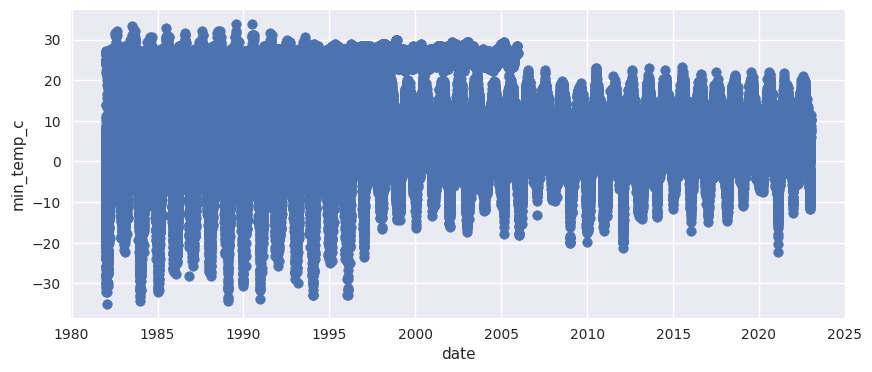

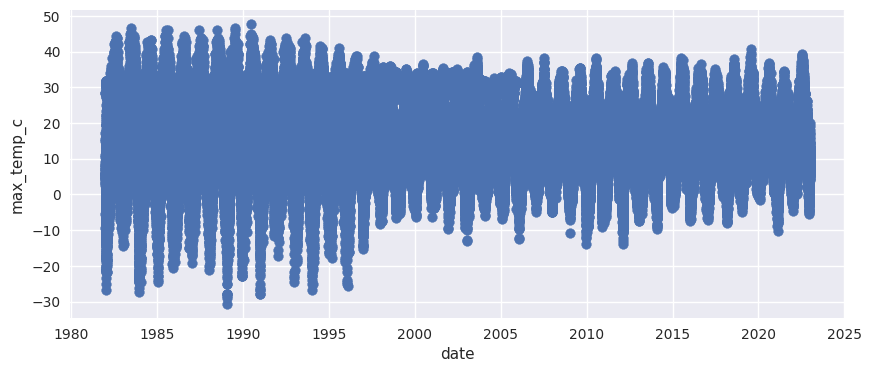

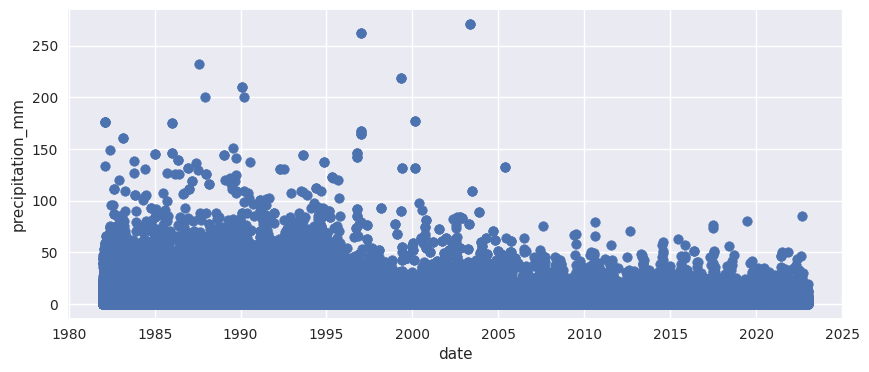

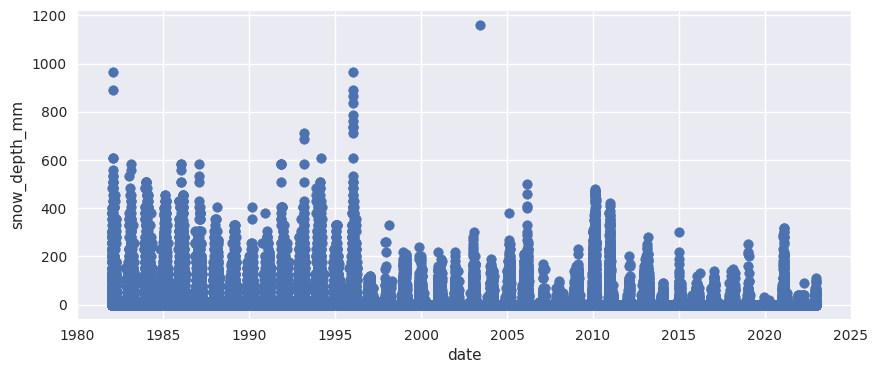

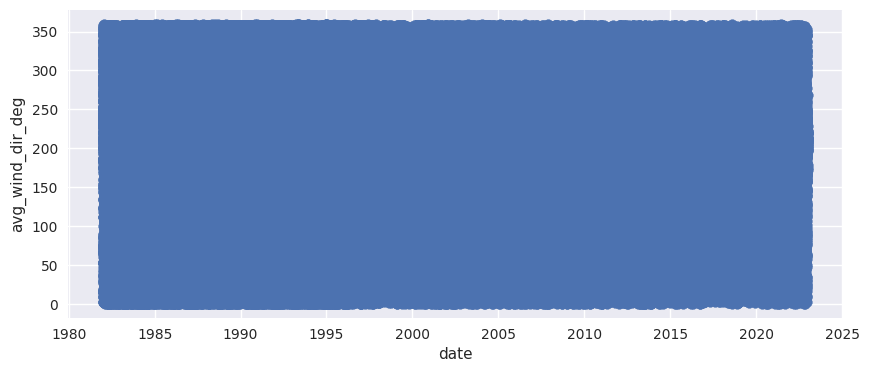

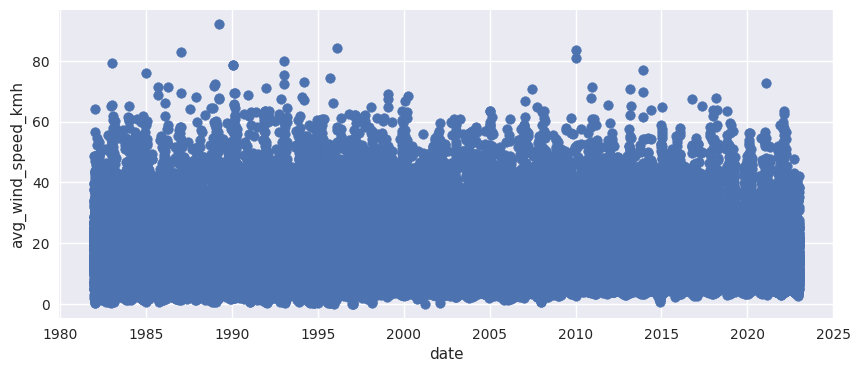

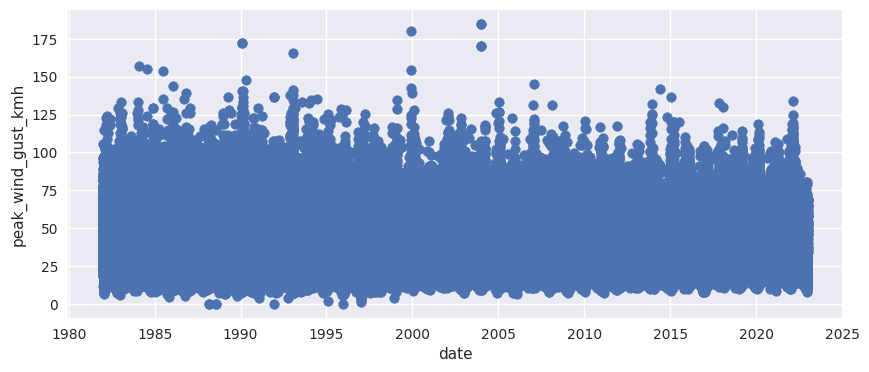

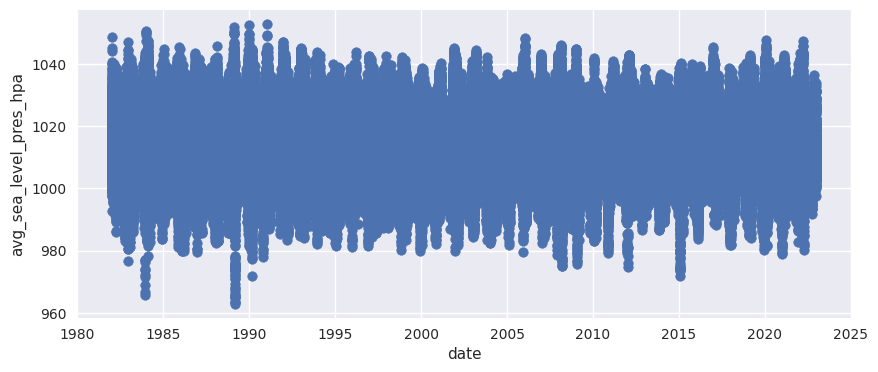

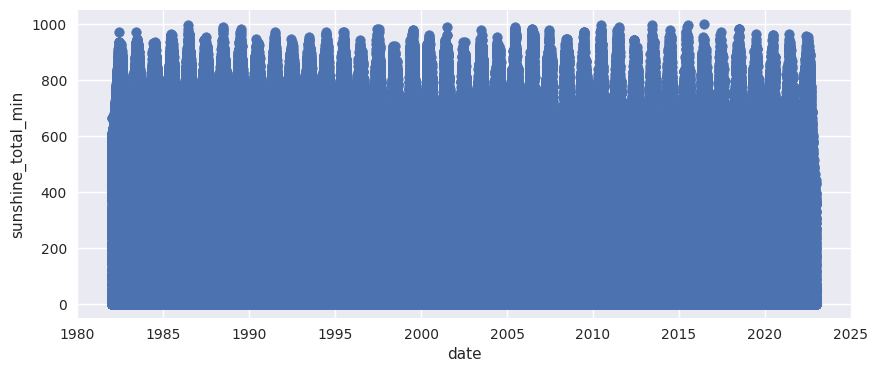

In [52]:
# subset country = United States for Global Weather data
plt.style.use('seaborn')

wfeatures = ['avg_temp_c', 'min_temp_c',  'max_temp_c', 'precipitation_mm', 'snow_depth_mm', 'avg_wind_dir_deg', 'avg_wind_speed_kmh',
             'peak_wind_gust_kmh', 'avg_sea_level_pres_hpa', 'sunshine_total_min']

 # scatter plots
x = cities_weather['date']

for col in wfeatures:
      plt.figure(figsize=(10, 4))
      y = cities_weather[col]
      plt.scatter(x, y)
      plt.xlabel('date')
      plt.ylabel(col)
      plt.show()

#### Apply aggregate functions to the grouped data

In [55]:
# Grouping by 'contry' and 'season' and calculating statistics
grouped_data = cities_weather.groupby(['country', 'season'])

agg_results = grouped_data.avg_temp_c.agg(['mean', 'min', 'max'])
agg_results

mean   min   max
country       season                       
Denmark       Autumn  10.569520   0.0  22.0
              Spring   7.500203   0.0  20.6
              Summer  17.100869  10.4  25.1
              Winter   3.148996   0.0  12.1
Germany       Autumn   9.963284   0.0  25.1
              Spring   9.265923   0.0  26.3
              Summer  17.857962   6.6  30.0
              Winter   3.127389   0.0  15.7
Samoa         Autumn  28.112944  24.8  30.0
              Spring  27.548418  24.5  30.0
              Summer  28.257838  25.0  30.0
              Winter  26.997080  22.7  29.5
Sweden        Autumn  10.021985   0.0  21.0
              Spring   6.656527   0.0  19.7
              Summer  16.302888   7.4  25.5
              Winter   2.491926   0.0  11.3
Switzerland   Autumn   9.943351   0.0  22.8
              Spring   9.837140   0.0  24.0
              Summer  18.781869   7.1  28.5
              Winter   2.533462   0.0  13.5
United States Autumn  13.319248   0.0  30.0
              Spring  11.980205   0.0  30.0
              Summer  23.527171   2.9  30.0
              Winter   3.675106   0.0  27.7

In [56]:
agg_results = grouped_data.max_temp_c.agg(['mean', 'min', 'max'])
agg_results

mean   min   max
country       season                       
Denmark       Autumn  12.611555  -2.0  29.5
              Spring  10.434399  -3.8  29.7
              Summer  20.244876  11.6  34.0
              Winter   4.307898  -6.9  14.6
Germany       Autumn  13.747790  -7.6  34.0
              Spring  13.955741  -7.0  33.8
              Summer  23.060295   9.7  40.7
              Winter   4.715531 -19.2  21.5
Samoa         Autumn  30.454538  26.7  34.4
              Spring  29.824108  25.0  34.4
              Summer  30.832162  26.7  35.6
              Winter  28.997263  23.9  35.0
Sweden        Autumn  12.076380  -2.1  28.6
              Spring   9.360434  -6.0  27.7
              Summer  19.331242  10.1  32.2
              Winter   3.565209  -9.8  16.3
Switzerland   Autumn  13.997655  -4.7  30.9
              Spring  15.271565  -2.8  32.2
              Summer  24.552018  10.0  36.7
              Winter   4.557640 -14.0  19.4
United States Autumn  18.521537 -20.6  44.4
              Spring  17.374338 -17.8  45.0
              Summer  29.629979   6.7  47.8
              Winter   5.593135 -30.6  32.8

In [57]:
agg_results = grouped_data.min_temp_c.agg(['mean', 'min', 'max'])
agg_results

mean   min   max
country       season                       
Denmark       Autumn   8.403424  -6.5  18.8
              Spring   4.773567  -9.9  14.8
              Summer  14.060973   4.7  21.2
              Winter   0.936546 -11.5   9.7
Germany       Autumn   6.374774 -11.8  19.6
              Spring   4.448334 -18.7  19.8
              Summer  12.740284   0.8  24.9
              Winter  -0.631932 -24.6  12.6
Samoa         Autumn  25.756906  21.1  29.4
              Spring  25.432458  21.1  30.0
              Summer  25.693423  21.1  30.0
              Winter  25.080231  18.3  28.3
Sweden        Autumn   8.002569  -7.4  19.4
              Spring   4.255658 -12.1  15.2
              Summer  13.708292   4.8  22.1
              Winter   0.005551 -17.0   9.3
Switzerland   Autumn   6.894367  -9.0  19.6
              Spring   5.207921 -12.5  18.8
              Summer  13.992077   4.4  22.2
              Winter  -0.796353 -19.0  10.9
United States Autumn   7.926194 -28.3  32.2
              Spring   6.216567 -25.0  30.0
              Summer  17.917882   0.0  33.9
              Winter  -3.694180 -35.0  25.6

# Time Series Visualization
source - https://www.kaggle.com/code/prashant111/complete-guide-on-time-series-analysis-in-python

For the visual timeseries analysis included the avg_temp_c merged Global Weather data 

In [71]:
def plot_df(df, x, y, title="Weather data", xlabel='date', ylabel='avg_temp_c', dpi=100, color=''):
    plt.figure(figsize=(15,4), dpi=dpi)
    plt.plot(x, y, color=color)        
    plt.gca().set(title=title, xlabel=xlabel, ylabel=ylabel)
    plt.show()

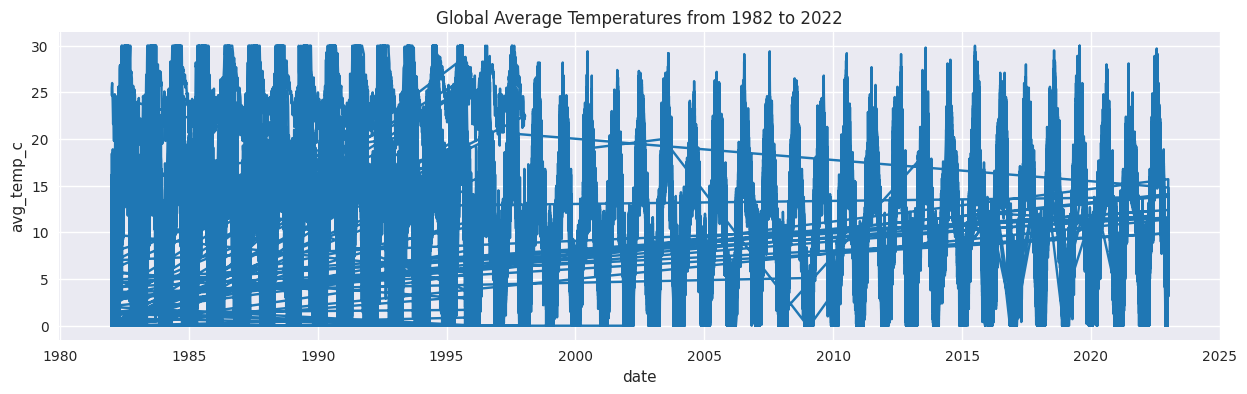

In [72]:
# cities_weather - all countries
plot_df(cities_weather, x=cities_weather['date'], y=cities_weather['avg_temp_c'], title='Global Average Temperatures from 1982 to 2022', color='tab:blue')

## Patterns in a Time Series
(source https://otexts.com/fpp3/tspatterns.html)

Composition of Time Series 
- trend - when there is a long-term increase or decrease in the data.
- seasonality - when a time series is affected by seasonal factors such as the time of the year or the day of the week. 
- cyclic (residuals) - when the data exhibit rises and falls that are not of a fixed frequency
​
---
source https://www.kaggle.com/code/prashant111/complete-guide-on-time-series-analysis-in-python
​

Visualizations
- Decomposition of a Time Series
- Detrend a Time Series
- Autocorrelation and Partial Autocorrelation Functions
- Lag plots

#### Trend and Seasonality of a Timeseries
Visualize the Trend and Seasonality by plotting the date and avg_temp_c columns

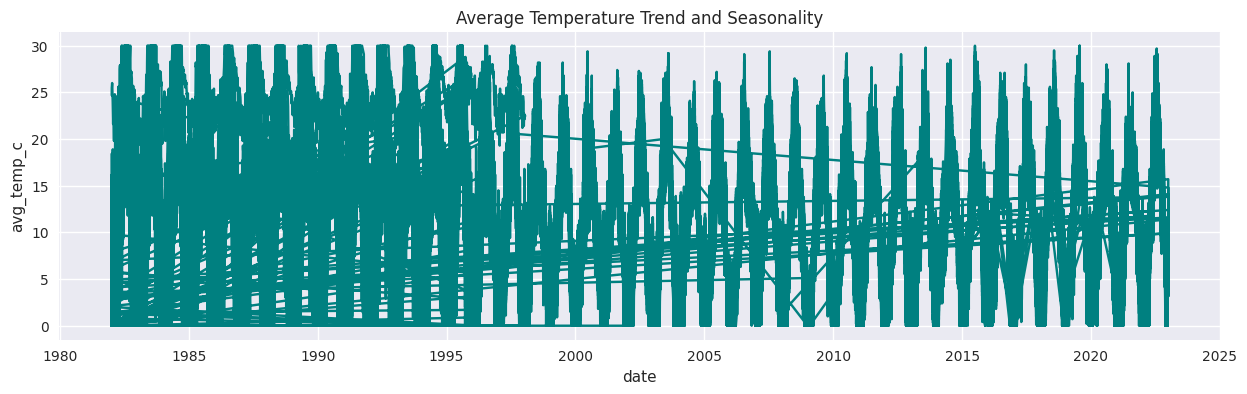

In [73]:
plot_df(cities_weather, x=cities_weather['date'], y=cities_weather['avg_temp_c'], title='Average Temperature Trend and Seasonality', color='teal')

#### Decomposition of a Time Series
Visualize the seasonal decompose function

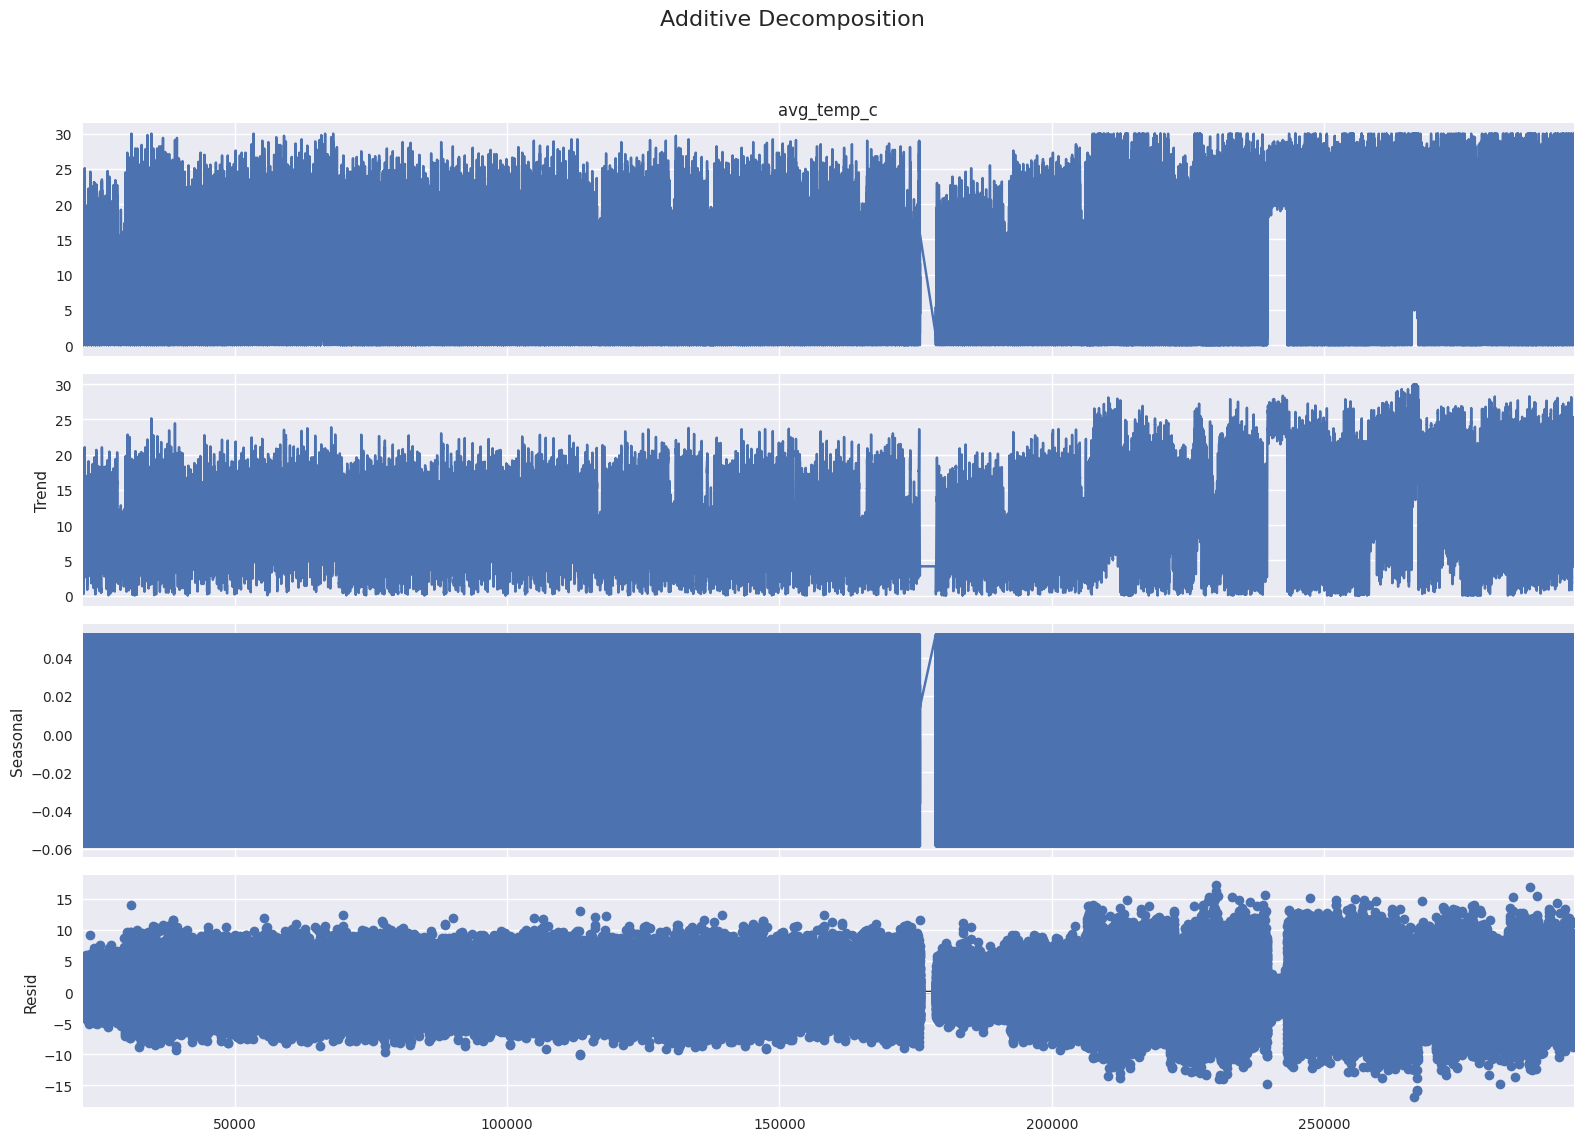

In [74]:
# Additive Decomposition
additive_decomposition = seasonal_decompose(cities_weather['avg_temp_c'], model='additive', period=30)

# Plot
plt.rcParams.update({'figure.figsize': (16,12)})

additive_decomposition.plot().suptitle('Additive Decomposition', fontsize=16)
plt.tight_layout(rect=[0, 0.03, 1, 0.95])

plt.show()

 #### Detrend a Time Series
 Visualize the detrend function

Text(0.5, 1.0, 'Average Temp (C) detrended by subtracting the least squares fit')

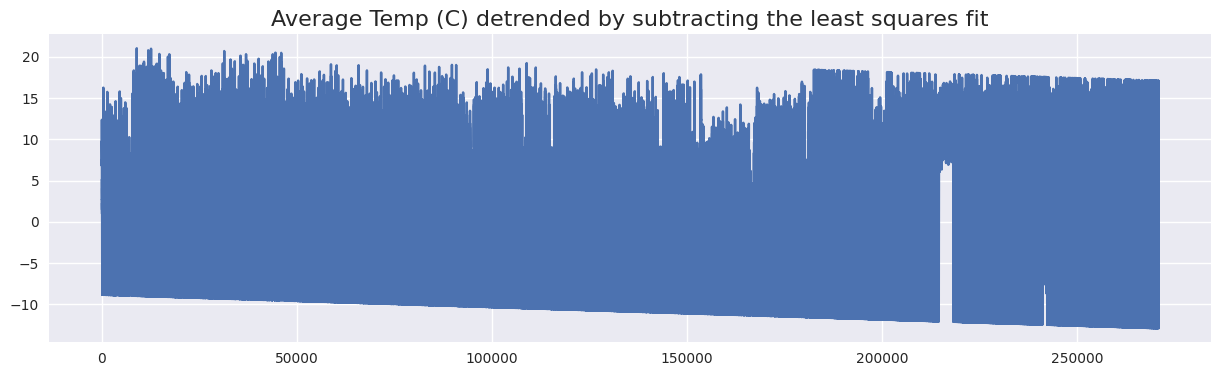

In [79]:
detrended = signal.detrend(cities_weather['avg_temp_c'].values)
plt.rcParams['figure.figsize'] = [15, 4] 
plt.plot(detrended)
plt.title('Average Temp (C) detrended by subtracting the least squares fit', fontsize=16)

<Axes: xlabel='Lag', ylabel='Autocorrelation'>

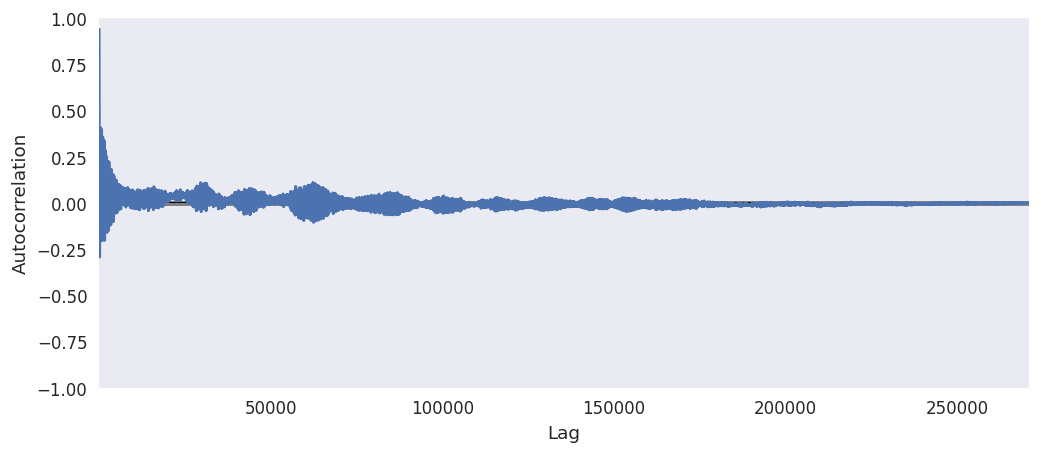

In [83]:
# Test for seasonality
# Draw Plot
plt.rcParams.update({'figure.figsize':(10,4), 'figure.dpi':120})
autocorrelation_plot(cities_weather['avg_temp_c'].tolist())

#### ACF and PACF
Visualize the Autocorrelation and Partial Autocorrelation function

Autocorrelation - the measure of correlation between a given time series with its own previous values (lagged version of that time series over successive time periods). 

Partial Autocorrelation - the correlation of a series and its lag, excluding the correlation contributions from the intermediate lags.

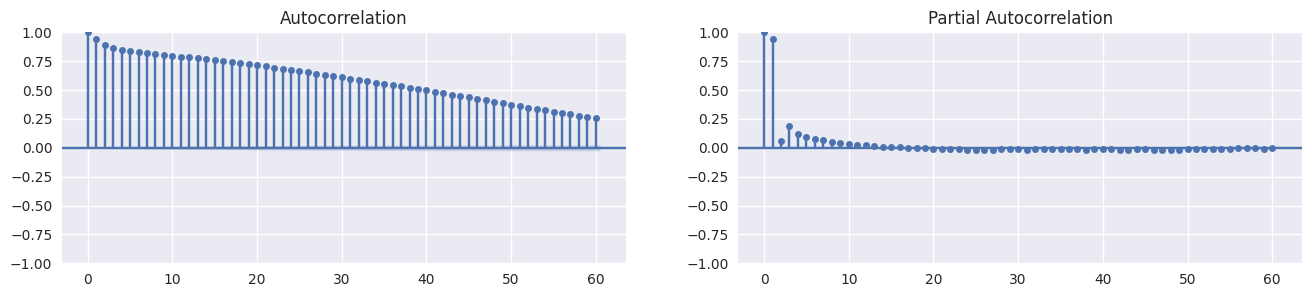

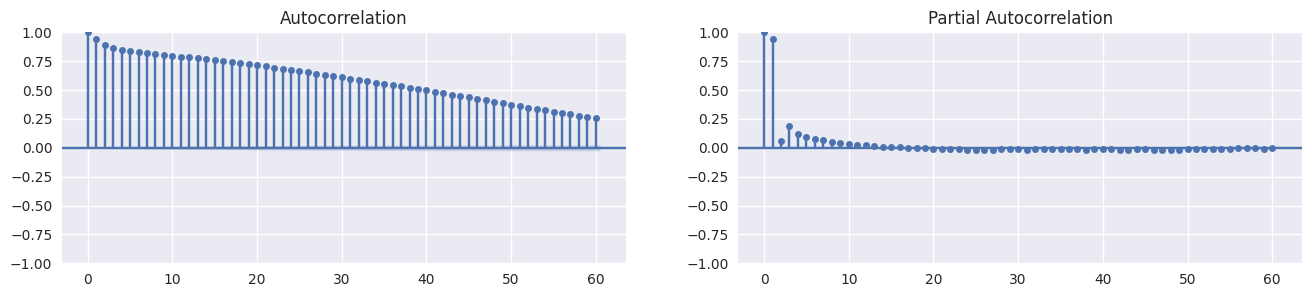

In [85]:
# Draw Plot
fig, axes = plt.subplots(1,2,figsize=(16,3), dpi= 100)
plot_acf(cities_weather['avg_temp_c'].tolist(), lags=60, ax=axes[0])
plot_pacf(cities_weather['avg_temp_c'].tolist(), lags=60, ax=axes[1])

##### Lag Plots
Visualize the Lag Plots

Lag plot - scatter plot of a time series against a lag (previous values) of itself in which the X-axis represents the dataset with some time units behind or ahead as compared to the Y-axis.

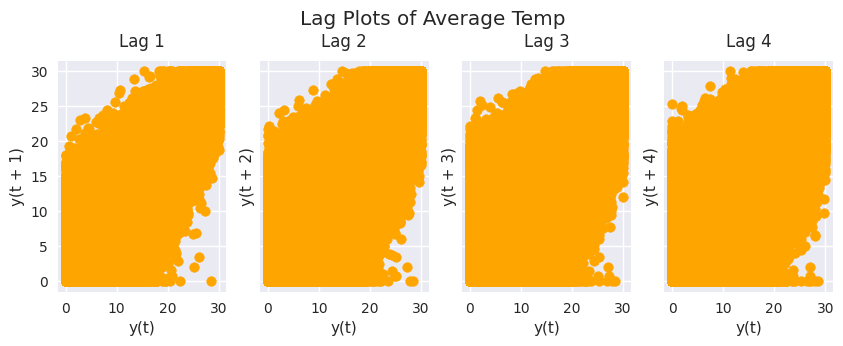

In [69]:
# Lag Plots
plt.rcParams.update({'ytick.left' : False, 'axes.titlepad':10})

# Plot
fig, axes = plt.subplots(1, 4, figsize=(10,3), sharex=True, sharey=True, dpi=100)
for i, ax in enumerate(axes.flatten()[:4]):
    lag_plot(cities_weather['avg_temp_c'], lag=i+1, ax=ax, c='orange')
    ax.set_title('Lag ' + str(i+1))

fig.suptitle('Lag Plots of Average Temp', y=1.05)
plt.show()

# Model Time Series

Check the dataset to see if it is stationary by using the Augmented Dickey-Fuller (ADF) or Kwiatkowski-Phillips-Schmidt-Shin (KPSS) statistical tests. 

### Augmented Dickey-Fuller (ADF) Test
source - https://www.oreilly.com/library/view/time-series-forecasting/9781617299889/ | https://www.analyticsvidhya.com/blog/2021/10/a-comprehensive-guide-to-time-series-analysis/

ADF Test (most popular) - review the staionarity of the data

The ADF test assumptions:
- p-value >0.05 Fail to reject (H0 - non-stationary)
- p-value <= 0.05 Accept (H1 - stationary)


In [59]:
ADF_result = adfuller(cities_weather['avg_temp_c'])

print(f'ADF Statistic: {ADF_result[0]}')
print(f'p-value: {ADF_result[1]:.3f}')

ADF Statistic: -45.14028231426015
p-value: 0.000


##### With a large negative ADF Statistic and a p-value much smaller than 0.05, the series is stationary.

<blockquote>
If the ADF statistic was not a large negative number and the p-value was not smaller than 0.05, the series would not be stationary. Being non-stationary would require applied transformations on the series. To stabilize the trend a x-order differencing can be applied (noted below).

<code>cities_weather_diff = np.diff(cities_weather['avg_temp_c'], n=x)</code> 

To verify re-check test for stationarity using the ADF test
    
<code> ADF_result = adfuller(cities_weather_diff)</code>   
 
<code> print(f'ADF Statistic: {ADF_result[0]}')</code>
<code> print(f'p-value: {ADF_result[1]}')</code>

Once the order of the moving average is identified the process can be moved to fit the model to the training/test data and start forecasting.
</blockquote>


####  Non-machine learning baseline
Added the mean of the data as a baseline reference

In [108]:
mean_value = cities_weather['avg_temp_c'].mean()
print("\nNon ML Baseline")
print(f'\nMean: {mean_value}')


Non ML Baseline

Mean: 11.514670619399359


### Encode data for modeling

source : https://www.kaggle.com/code/discdiver/category-encoders-examples/notebook

Classic Encoder - sklearn.preprocessing.LabelEncoder() code

In [117]:
# Make a copy of the dataframe to encode categorical data
cities_weather_enc2 = cities_weather.copy()    

#### Encode categorical variables for modeling with Label Encoder

In [118]:
# Label_encoder object
label_encoder = LabelEncoder()

# Encode label in column. 
cities_weather_enc2['city_name']= label_encoder.fit_transform(cities_weather_enc2['city_name'])
# Encode label in column. 
cities_weather_enc2['country']= label_encoder.fit_transform(cities_weather_enc2['country'])
# Encode label in column. 
cities_weather_enc2['season']= label_encoder.fit_transform(cities_weather_enc2['season'])

# display updated encoded dataframe - seasons, countries, cities
cities_weather_enc2.head(3)

date  season  avg_temp_c  min_temp_c  max_temp_c  precipitation_mm  \
1 1982-01-01       2        26.6        25.0        28.3              43.4   
3 1982-01-02       2        27.0        25.0        30.6               3.3   
5 1982-01-03       2        27.5        24.4        30.6               2.5   

   snow_depth_mm  avg_wind_dir_deg  avg_wind_speed_kmh  peak_wind_gust_kmh  \
1            0.0             338.0                28.7                85.0   
3            0.0               2.0                24.4                59.0   
5            0.0              54.0                14.5                37.1   

   avg_sea_level_pres_hpa  sunshine_total_min  city_name  country   latitude  \
1                  1008.6                30.0          2        2 -13.834369   
3                  1009.9               210.0          2        2 -13.834369   
5                  1010.1               486.0          2        2 -13.834369   

    longitude  
1 -171.769279  
3 -171.769279  
5 -171.769279

#### Train - Test

In [119]:
#Test - Train split for Simple Moving Average Model, MA, AR, ARMA, ARIMA, SARIMA

split_indx = int(0.9*len(cities_weather_enc2))  

train_data = cities_weather_enc2[0:split_indx]    # select the rows for training model.                            
test_data = cities_weather_enc2[split_indx:]      # rows to evaluate forecasting model performance  

## Classical Time Series Forecasting Methods MA, AR, ARMA, ARIMA, SARIMA

source https://machinelearningmastery.com/time-series-forecasting-methods-in-python-cheat-sheet/

### Moving Average Method using ARIMA (MA)
Moving Average: a model that smooths out variations in data by calculating the average of a rolling window of past observations.

In [120]:
# fit model for MA
ma_model = ARIMA(train_data['avg_temp_c'], order=(0, 0, 1))
ma_model_fit = ma_model.fit()

# make prediction                                      
pred_ma = ma_model_fit.predict(start=len(train_data), end=len(cities_weather_enc2)-1, typ="levels") 
print(pred_ma)

253799    21.401864
253800    11.328736
253801    11.328736
253802    11.328736
253803    11.328736
            ...    
281994    11.328736
281995    11.328736
281996    11.328736
281997    11.328736
281998    11.328736
Name: predicted_mean, Length: 28200, dtype: float64


In [121]:
ma_mae = mean_absolute_error(test_data['avg_temp_c'], pred_ma)
ma_mse = mean_squared_error(test_data['avg_temp_c'], pred_ma) 
ma_rmse = np.sqrt(ma_mse)
ma_mape = mean_absolute_percentage_error(test_data['avg_temp_c'], pred_ma)
print("MA Model Evaluation:")
print(f'\n MAE: {ma_mae}\n RMSE: {ma_rmse}\n MSE: {ma_mse}')

MA Model Evaluation:

 MAE: 8.264781205659801
 RMSE: 9.458916406914712
 MSE: 89.47109959300033


### Autoregressive Method using AutoReg (AR)
Auto-Regressive (AR): The model captures the linear relationship between the current data point and its past values, making it ideal for understanding long-term trends.

In [122]:
# fit model for AR
ar_model = AutoReg(train_data['avg_temp_c'], lags=4)
ar_model_fit = ar_model.fit()

# make prediction                                      
pred_ar = ar_model_fit.predict(start=len(train_data), end=len(cities_weather_enc2)-1) 
print(pred_ar)

253799    26.177889
253800    25.843807
253801    25.478440
253802    25.170849
253803    24.863797
            ...    
281994    11.328320
281995    11.328320
281996    11.328320
281997    11.328320
281998    11.328320
Length: 28200, dtype: float64


In [123]:
ar_mae = mean_absolute_error(test_data['avg_temp_c'], pred_ar)
ar_mse = mean_squared_error(test_data['avg_temp_c'], pred_ar) 
ar_rmse = np.sqrt(ar_mse)
ar_mape = mean_absolute_percentage_error(test_data['avg_temp_c'], pred_ar)
print("AR Model Evaluation:")
print(f'\n MAE: {ar_mae}\n RMSE: {ar_rmse}\n MSE: {ar_mse}')

AR Model Evaluation:

 MAE: 8.254628520604374
 RMSE: 9.450542221132388
 MSE: 89.31274827340589


### Autoregressive Moving Average (ARMA)

Autoregressive Moving Average (ARMA): Combining the AR and Moving Average models, ARMA can model both short-term fluctuations and long-term trends.

In [124]:
# fit model for ARMA
arma_model = ARIMA(train_data['avg_temp_c'], order=(2, 0, 1))
arma_model_fit = arma_model.fit()

# make prediction                                                 
pred_arma = arma_model_fit.predict(start=len(train_data), end=len(cities_weather_enc2)-1) 
print(pred_arma)

253799    26.007501
253800    25.171273
253801    24.577630
253802    23.864223
253803    23.295831
            ...    
281994    11.330156
281995    11.330156
281996    11.330156
281997    11.330156
281998    11.330156
Name: predicted_mean, Length: 28200, dtype: float64


In [125]:
arma_mae = mean_absolute_error(test_data['avg_temp_c'], pred_arma)
arma_mse = mean_squared_error(test_data['avg_temp_c'], pred_arma) 
arma_rmse = np.sqrt(arma_mse)
arma_mape = mean_absolute_percentage_error(test_data['avg_temp_c'], pred_arma)
print("ARMA Model Evaluation:")
print(f'\n MAE: {arma_mae}\n RMSE: {arma_rmse}\n MSE: {arma_mse}')

ARMA Model Evaluation:

 MAE: 8.255936977148608
 RMSE: 9.450717254375649
 MSE: 89.3160566221536


### Autoregressive Integrated Moving Average (ARIMA)

Autoregressive Integrated Moving Average (ARIMA): ARIMA takes into account differencing to make the time series stationary, making it versatile for various data patterns.

In [126]:
# fit model for ARIMA
arima_model = ARIMA(train_data['avg_temp_c'], order=(1, 1, 1))
arima_model_fit = arima_model.fit()

# make prediction                                                     
pred_arima = arima_model_fit.predict(start=len(train_data), end=len(cities_weather_enc2)-1, typ='levels') 
print(pred_arima)

253799    26.301340
253800    26.110696
253801    25.989003
253802    25.911322
253803    25.861736
            ...    
281994    25.774219
281995    25.774219
281996    25.774219
281997    25.774219
281998    25.774219
Name: predicted_mean, Length: 28200, dtype: float64


In [127]:
arima_mae = mean_absolute_error(test_data['avg_temp_c'], pred_arima)
arima_mse = mean_squared_error(test_data['avg_temp_c'], pred_arima) 
arima_rmse = np.sqrt(arima_mse)
arima_mape = mean_absolute_percentage_error(test_data['avg_temp_c'], pred_arima)
print("ARIMA Model Evaluation:")
print(f'\n MAE: {arima_mae}\n RMSE: {arima_rmse}\n MSE: {arima_mse}')

ARIMA Model Evaluation:

 MAE: 12.928940068533693
 RMSE: 15.634120275233007
 MSE: 244.4257167804518


In [128]:
arima_model_fit.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:             avg_temp_c   No. Observations:               253799
Model:                 ARIMA(1, 1, 1)   Log Likelihood             -586496.905
Date:                Sun, 22 Oct 2023   AIC                        1172999.809
Time:                        23:58:47   BIC                        1173031.142
Sample:                             0   HQIC                       1173008.937
                             - 253799                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.6383      0.002    276.720      0.000       0.634       0.643
ma.L1         -0.8668      0.002   -567.508      0.000      -0.870      -0.864
sigma2         5.9529      0.011    557.479      0.000       5.932       5.974
===================================================================================
Ljung-Box (L1) (Q):                1156.62   Jarque-Bera (JB):            115568.77
Prob(Q):                              0.00   Prob(JB):                         0.00
Heteroskedasticity (H):               2.51   Skew:                            -0.01
Prob(H) (two-sided):                  0.00   Kurtosis:                         6.31
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

### Seasonal Autoregressive Integrated Moving-Average (SARIMA)
Seasonal Autoregressive Integrated Moving-Average (SARIMA): SARIMA extends ARIMA by considering seasonal components, crucial for weather data with recurring patterns.

In [129]:
# fit model for SARIMA                                              
sarima_model = SARIMAX(train_data['avg_temp_c'], order=(2, 0, 2), seasonal_order=(1, 1, 2, 4)) 
sarima_model_fit = sarima_model.fit(disp=False)

# make prediction                                                    
pred_sarima = sarima_model_fit.predict(start=len(train_data), end=len(cities_weather_enc2)-1, typ='levels') 
print(pred_sarima)  

253799    26.182749
253800    25.797262
253801    25.564614
253802    25.396610
253803    25.264138
            ...    
281994    11.387004
281995    11.384528
281996    11.386946
281997    11.392603
281998    11.387004
Name: predicted_mean, Length: 28200, dtype: float64


In [130]:
sarima_mae = mean_absolute_error(test_data['avg_temp_c'], pred_sarima)
sarima_mse = mean_squared_error(test_data['avg_temp_c'], pred_sarima)
sarima_rmse = np.sqrt(sarima_mse)
sarima_mape = mean_absolute_percentage_error(test_data['avg_temp_c'], pred_sarima)
print("SARIMA Model Evaluation:")
print(f'\n MAE: {sarima_mae}\n RMSE: {sarima_rmse}\n MSE: {sarima_mse}')

SARIMA Model Evaluation:

 MAE: 8.260715416894545
 RMSE: 9.454934262049656
 MSE: 89.39578189968047


### LSTM Forecast

source:  https://github.com/marcopeix/TimeSeriesForecastingInPython/blob/master/CH18/CH18_modeling.ipynb

LSTM (Long Short-Term Memory): Leveraging the power of deep learning, LSTM captures complex temporal dependencies, enabling precise forecasting in dynamic weather scenarios.

In [131]:
# Make a copy of the dataframe to set date column as the index
cities_weather_lstm = cities_weather_enc2.copy()

# set date as the index
cities_weather_lstm = cities_weather_lstm.set_index("date")

In [132]:
cities_weather_lstm.head(5)

season  avg_temp_c  min_temp_c  max_temp_c  precipitation_mm  \
date                                                                       
1982-01-01       2        26.6        25.0        28.3              43.4   
1982-01-02       2        27.0        25.0        30.6               3.3   
1982-01-03       2        27.5        24.4        30.6               2.5   
1982-01-04       2        27.8        25.0        30.6               3.3   
1982-01-05       2        28.3        26.1        31.1               6.6   

            snow_depth_mm  avg_wind_dir_deg  avg_wind_speed_kmh  \
date                                                              
1982-01-01            0.0             338.0                28.7   
1982-01-02            0.0               2.0                24.4   
1982-01-03            0.0              54.0                14.5   
1982-01-04            0.0              52.0                18.8   
1982-01-05            0.0              52.0                17.9   

            peak_wind_gust_kmh  avg_sea_level_pres_hpa  sunshine_total_min  \
date                                                                         
1982-01-01                85.0                  1008.6                30.0   
1982-01-02                59.0                  1009.9               210.0   
1982-01-03                37.1                  1010.1               486.0   
1982-01-04                42.5                  1010.9               468.0   
1982-01-05                48.2                  1012.6               258.0   

            city_name  country   latitude   longitude  
date                                                   
1982-01-01          2        2 -13.834369 -171.769279  
1982-01-02          2        2 -13.834369 -171.769279  
1982-01-03          2        2 -13.834369 -171.769279  
1982-01-04          2        2 -13.834369 -171.769279  
1982-01-05          2        2 -13.834369 -171.769279

In [134]:
# train-test source
#https://colab.research.google.com/github/tensorflow/docs/blob/master/site/en/tutorials/structured_data/time_series.ipynb#scrollTo=ia-MPAHxbInX

n = len(cities_weather_lstm)
train_lstm = cities_weather_lstm[0:int(n*0.7)]
val_lstm = cities_weather_lstm[int(n*0.7):int(n*0.9)]
test_lstm = cities_weather_lstm[int(n*0.9):]

num_features = cities_weather_lstm.shape[1]

In [135]:
# DataWindow class

class DataWindow():
    def __init__(self, input_width, label_width, shift, 
                 train_df=train_lstm, val_df=val_lstm, test_df=test_lstm, 
                 label_columns=None):
        
        self.train_df = train_lstm
        self.val_df = val_lstm
        self.test_df = test_lstm
        
        self.label_columns = label_columns
        if label_columns is not None:
            self.label_columns_indices = {name: i for i, name in enumerate(label_columns)}
        self.column_indices = {name: i for i, name in enumerate(train_lstm.columns)}
        
        self.input_width = input_width
        self.label_width = label_width
        self.shift = shift
        
        self.total_window_size = input_width + shift
        
        self.input_slice = slice(0, input_width)
        self.input_indices = np.arange(self.total_window_size)[self.input_slice]
        
        self.label_start = self.total_window_size - self.label_width
        self.labels_slice = slice(self.label_start, None)
        self.label_indices = np.arange(self.total_window_size)[self.labels_slice]
    
    def split_to_inputs_labels(self, features):
        inputs = features[:, self.input_slice, :]
        labels = features[:, self.labels_slice, :]
        if self.label_columns is not None:
            labels = tf.stack(
                [labels[:,:,self.column_indices[name]] for name in self.label_columns],
                axis=-1
            )
        inputs.set_shape([None, self.input_width, None])
        labels.set_shape([None, self.label_width, None])
        
        return inputs, labels
    
    def plot(self, model=None, plot_col='avg_temp_c', max_subplots=3):
        inputs, labels = self.sample_batch
        
        plt.figure(figsize=(12, 8))
        plot_col_index = self.column_indices[plot_col]
        max_n = min(max_subplots, len(inputs))
        
        for n in range(max_n):
            plt.subplot(3, 1, n+1)
            plt.ylabel(f'{plot_col} [scaled]')
            plt.plot(self.input_indices, inputs[n, :, plot_col_index],
                     label='Inputs', marker='.', zorder=-10)

            if self.label_columns:
              label_col_index = self.label_columns_indices.get(plot_col, None)
            else:
              label_col_index = plot_col_index

            if label_col_index is None:
              continue

            plt.scatter(self.label_indices, labels[n, :, label_col_index],
                        edgecolors='k', marker='s', label='Labels', c='green', s=64)
            if model is not None:
              predictions = model(inputs)
              plt.scatter(self.label_indices, predictions[n, :, label_col_index],
                          marker='X', edgecolors='k', label='Predictions',
                          c='orange', s=64)

            if n == 0:
              plt.legend()

        plt.xlabel('Time (h)')
        
    def make_dataset(self, data):
        data = np.array(data, dtype=np.float32)
        ds = tf.keras.preprocessing.timeseries_dataset_from_array(
            data=data,
            targets=None,
            sequence_length=self.total_window_size,
            sequence_stride=1,
            shuffle=True,
            batch_size=32
        )
        
        ds = ds.map(self.split_to_inputs_labels)
        return ds
    
    @property
    def train(self):
        return self.make_dataset(self.train_df)
    
    @property
    def val(self):
        return self.make_dataset(self.val_df)
    
    @property
    def test(self):
        return self.make_dataset(self.test_df)
    
    @property
    def sample_batch(self):
        result = getattr(self, '_sample_batch', None)
        if result is None:
            result = next(iter(self.train))
            self._sample_batch = result
        return result

def compile_and_fit(model, window, patience=3, max_epochs=50):
    early_stopping = EarlyStopping(monitor='val_loss',
                                   patience=patience,
                                   mode='min')
    
    model.compile(loss=MeanSquaredError(),
                  optimizer=Adam(),
                  metrics=[MeanAbsoluteError()])
    
    history = model.fit(window.train,
                       epochs=max_epochs,
                       validation_data=window.val,
                       callbacks=[early_stopping])
    
    return history

In [136]:
def compile_and_fit(model, window, patience=3, max_epochs=50):
    early_stopping = EarlyStopping(monitor='val_loss',
                                   patience=patience,
                                   mode='min')
    
    model.compile(loss=MeanSquaredError(),
                  optimizer=Adam(),
                  metrics=[MeanAbsoluteError()])
    
    history = model.fit(window.train,
                       epochs=max_epochs,
                       validation_data=window.val,
                       callbacks=[early_stopping])
    
    return history

In [137]:
column_indices = {name: i for i, name in enumerate(train_lstm.columns)}

In [93]:
column_indices

{'season': 0,
 'avg_temp_c': 1,
 'min_temp_c': 2,
 'max_temp_c': 3,
 'precipitation_mm': 4,
 'snow_depth_mm': 5,
 'avg_wind_dir_deg': 6,
 'avg_wind_speed_kmh': 7,
 'peak_wind_gust_kmh': 8,
 'avg_sea_level_pres_hpa': 9,
 'sunshine_total_min': 10,
 'city_name': 11,
 'country': 12,
 'latitude': 13,
 'longitude': 14,
 'sma_forecast': 15}

In [138]:
# Baseline models
multi_window = DataWindow(input_width=24, label_width=24, shift=24, label_columns=['avg_temp_c'])

In [96]:
val_performance = {}
performance = {}

In [139]:
lstm_model = Sequential([
    LSTM(32, return_sequences=True),
    Dense(1, kernel_initializer=tf.initializers.zeros),
])

history = compile_and_fit(lstm_model, multi_window)

val_performance['LSTM'] = lstm_model.evaluate(multi_window.val)
performance['LSTM'] = lstm_model.evaluate(multi_window.test, verbose=0)

Epoch 1/50
6168/6168 [==============================] - 96s 15ms/step - loss: 37.0844 - mean_absolute_error: 4.6828 - val_loss: 57.9877 - val_mean_absolute_error: 6.3699
Epoch 2/50
6168/6168 [==============================] - 91s 15ms/step - loss: 17.3923 - mean_absolute_error: 3.2983 - val_loss: 54.3341 - val_mean_absolute_error: 6.0913
Epoch 3/50
6168/6168 [==============================] - 89s 14ms/step - loss: 16.3821 - mean_absolute_error: 3.1576 - val_loss: 52.5515 - val_mean_absolute_error: 5.9679
Epoch 4/50
6168/6168 [==============================] - 90s 15ms/step - loss: 15.7206 - mean_absolute_error: 3.0946 - val_loss: 52.4501 - val_mean_absolute_error: 5.9844
Epoch 5/50
6168/6168 [==============================] - 91s 15ms/step - loss: 15.3090 - mean_absolute_error: 3.0556 - val_loss: 49.5686 - val_mean_absolute_error: 5.7946
Epoch 6/50
6168/6168 [==============================] - 89s 14ms/step - loss: 15.1235 - mean_absolute_error: 3.0378 - val_loss: 50.2292 - val_mean_abs

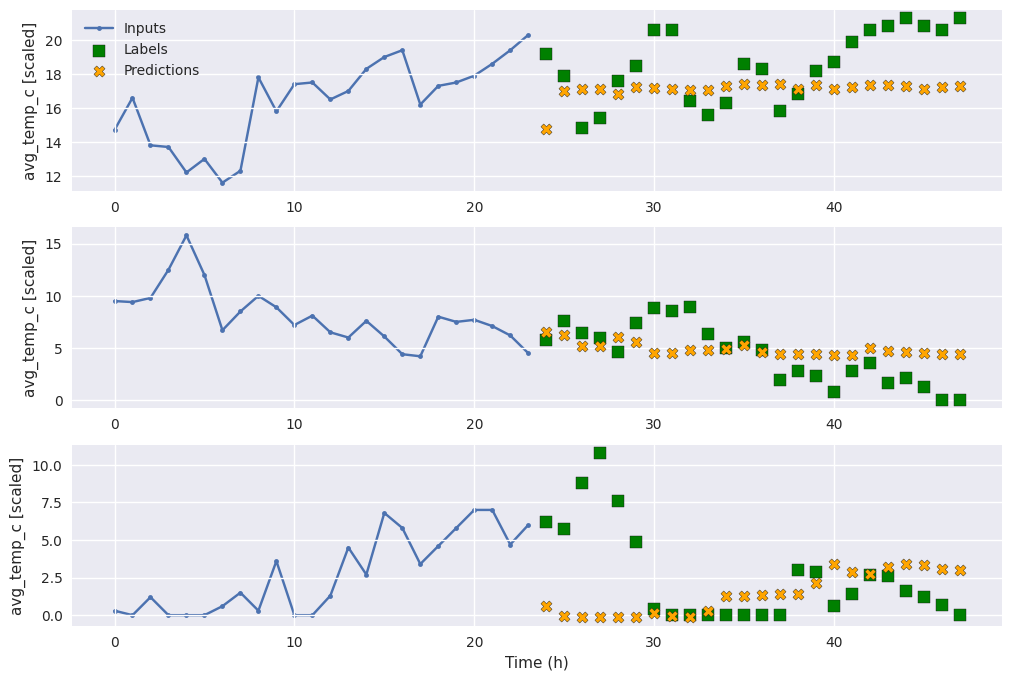

In [140]:
multi_window.plot(lstm_model)

### Prophet Forecast
sources: 
https://github.com/dipanjanS/practical-machine-learning-with-python/blob/master/notebooks/Ch11_Forecasting_Stock_and_Commodity_Prices/notebook_stock_prediction_fbprophet.ipynb
https://colab.research.google.com/drive/1Zz--8n9HsxHpNUm1GNFm2G4db3r7pKqR#scrollTo=0dd91ffd

Prophet: Developed by Facebook, excellent at handling data with recurring patterns, detects changepoints in the data, and handles missing data and outliers gracefully.

In [141]:
cities_weather_pr = cities_weather_enc2[["date", "avg_temp_c"]]

In [142]:
cities_weather_pr.head(3)

date  avg_temp_c
1 1982-01-01        26.6
3 1982-01-02        27.0
5 1982-01-03        27.5

In [143]:
cities_weather_pr.columns = ['ds', 'y']

In [144]:
# prepare train and test sets
train_size_pr = int(cities_weather_pr.shape[0]*0.9)
train_pr = cities_weather_pr.iloc[:train_size_pr]
test_pr = cities_weather_pr.iloc[train_size_pr+1:]

In [145]:
# build a prophet model
m = Prophet()
m.fit(train_pr)

00:29:37 - cmdstanpy - INFO - Chain [1] start processing
00:30:52 - cmdstanpy - INFO - Chain [1] done processing


In [146]:
# prepare a future dataframe
test_dates = m.make_future_dataframe(4, freq='Y')

# forecast values
forecast = m.predict(test_dates)

In [147]:
forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail()

ds      yhat  yhat_lower  yhat_upper
14953 2022-12-31  3.913042   -3.106499   10.780939
14954 2023-12-31  4.086239   -3.024480   10.400968
14955 2024-12-31  4.158573   -3.184371   11.403929
14956 2025-12-31  4.272163   -3.004950   11.087677
14957 2026-12-31  4.333408   -2.890219   11.347717

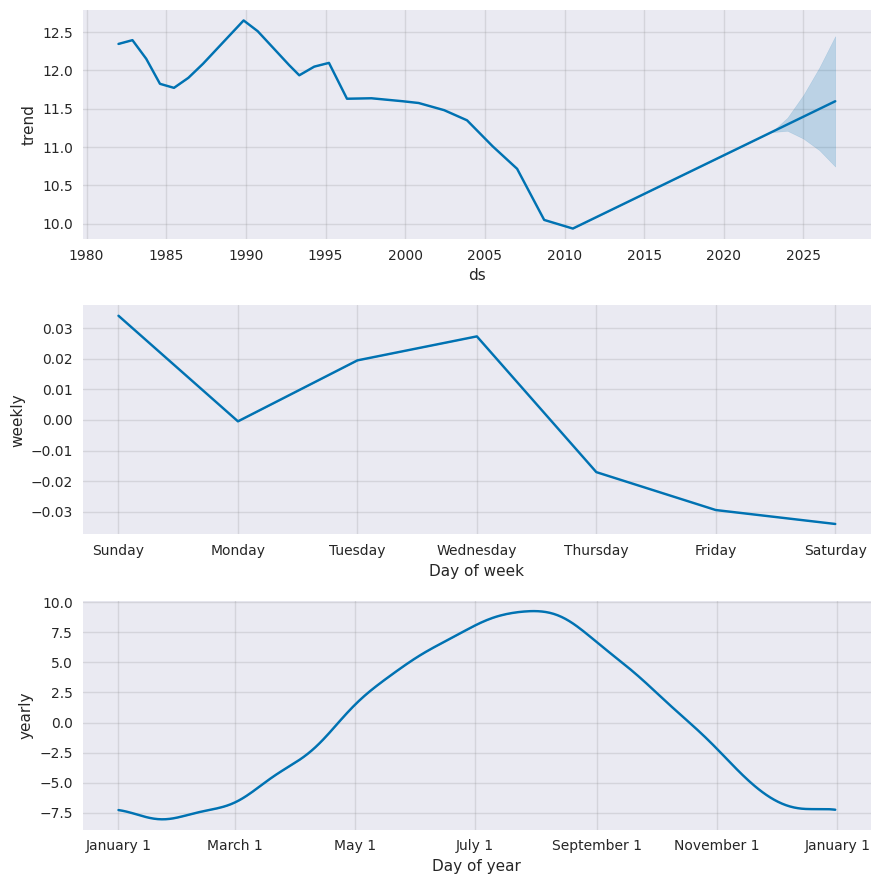

In [148]:
components_plot = m.plot_components(forecast)

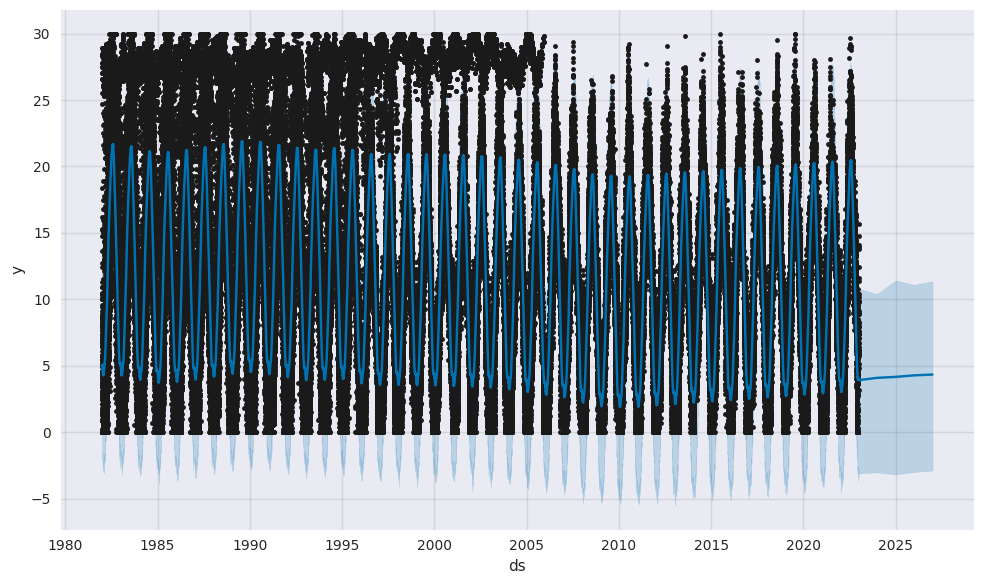

In [149]:
forecast_plot = m.plot(forecast)

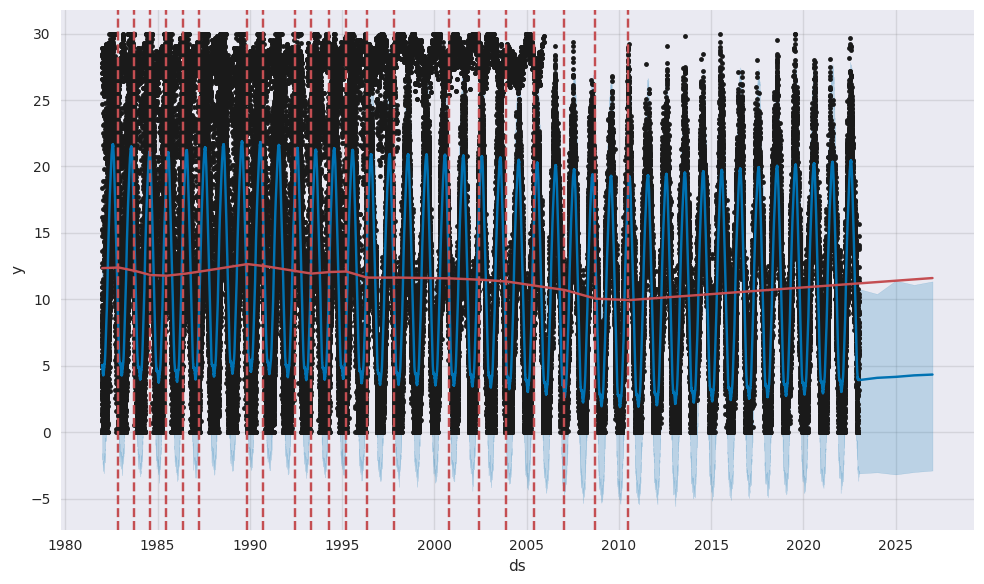

In [150]:
chgpoints_plot = m.plot(forecast)
a = add_changepoints_to_plot(chgpoints_plot.gca(), m, forecast)

00:32:51 - cmdstanpy - INFO - Chain [1] start processing
00:35:54 - cmdstanpy - INFO - Chain [1] done processing


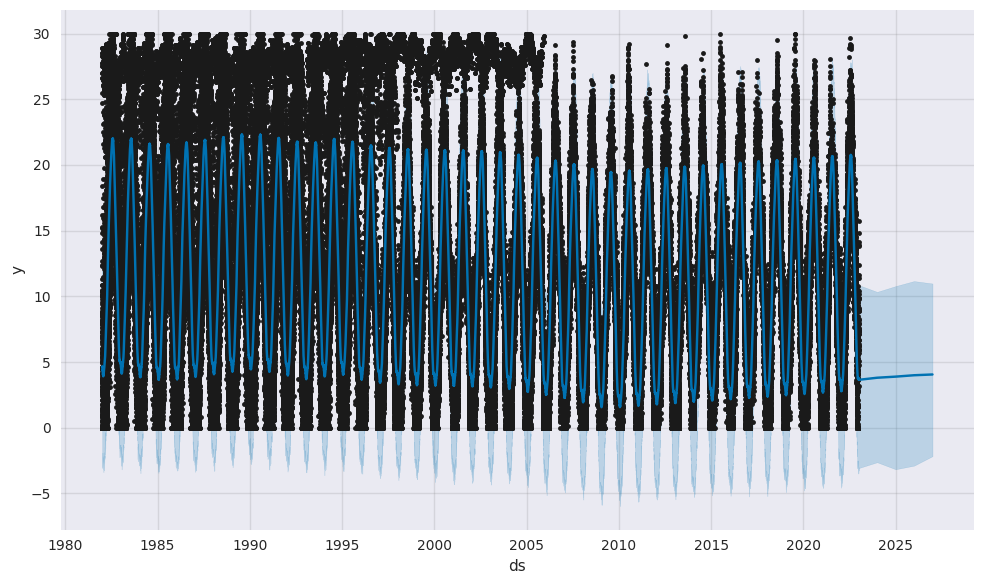

In [151]:
m = Prophet(changepoint_prior_scale=0.05) #0.5 #0.001
forecast = m.fit(cities_weather_pr).predict(test_dates)
fig = m.plot(forecast)